In [1]:
from shearletNN.shearlets import getcomplexshearlets2D
from shearletNN.shearlet_utils import (
    frequency_shearlet_transform,
    spatial_shearlet_transform,
    ShearletTransformLoader,
    shifted_frequency_shearlet_transform,
    shifted_spatial_shearlet_transform,
    hartley_shearlet_transform,
)
from shearletNN.complex_resnet import (
    complex_resnet18,
    complex_resnet34,
    complex_resnet50,
)

from shearletNN.layers import CGELU, CReLU

import torch
import torchvision
from torchvision.transforms import v2
from torchvision import transforms

import gc
from tqdm import tqdm
import matplotlib.pyplot as plt


patch_size = 16
image_size = 16

rows, cols = image_size, image_size


shearlets, shearletIdxs, RMS, dualFrameWeights = getcomplexshearlets2D(
    rows,
    cols,
    1,  # scales per octave
    3,  # shear level (something like O(log of directions))
    1,  # octaves
    0.5,  # alpha
    wavelet_eff_support=image_size,
    gaussian_eff_support=image_size,
)

shearlets = torch.tensor(shearlets).permute(2, 0, 1).type(torch.complex64).to(0)

In [2]:
from torchvision.models import resnet50
from thop import profile
model = resnet50().to(0)
input = torch.randn(1, 3, 224, 224).to(0)
macs, params = profile(model, inputs=(input, ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


In [3]:
macs, params

(4133742592.0, 25557032.0)

In [4]:
from torch.amp import GradScaler, autocast

def train(model, optimizer, loader, accumulate=1):
    model.train()
    loss = torch.nn.CrossEntropyLoss()

    scaler = GradScaler()

    for i, (X, y) in tqdm(enumerate(loader)):
        out = model(X.to(0))

        with autocast(device_type='cuda', dtype=torch.float16):
            l = loss(out, y.to(0)) / accumulate

        scaler.scale(l).backward()

        if i % accumulate == (accumulate - 1):
            scaler.step(optimizer) # .step()
            scaler.update()
            optimizer.zero_grad()


def accuracy(output, target, topk=(1,)):
    output = output.to(torch.device("cpu"))
    target = target.to(torch.device("cpu"))
    maxk = max(topk)
    batch_size = target.shape[0]

    _, idx = output.sort(dim=1, descending=True)
    pred = idx.narrow(1, 0, maxk).t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(dim=0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def epoch_accuracy(loader_s, student):
    student.eval()

    out_epoch_s = [
        accuracy(student(L.to(0)), y)[0].detach().cpu().item() for L, y in loader_s
    ]

    student.train()

    return sum(out_epoch_s) / len(out_epoch_s)


def test(network, test_loader):
    network.eval().to(0)
    test_loss = 0
    correct = 0
    total = 0
    test_losses = []
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.to(0))
            test_loss += torch.nn.CrossEntropyLoss()(output, target.to(0)).item()
            pred = output.data.max(1, keepdim=True)[1].cpu()
            correct += pred.eq(target.data.view_as(pred)).sum()
            total += target.shape[0]
        test_loss /= total
        test_losses.append(test_loss)
        print(
            "\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
                test_loss, correct, total, 100.0 * correct / total
            )
        )


class IndexSubsetDataset:
    def __init__(self, ds, inds):
        self.ds = ds
        self.inds = inds

    def __iter__(self):
        for i in range(len(self.inds)):
            yield self[i]

    def __getitem__(self, i):
        return self.ds[self.inds[i]]

    def __len__(self):
        return len(self.inds)


def linearleaves(module):
    # returns a list of pairs of (parent, submodule_name) pairs for all submodule leaves of the current module
    if isinstance(module, torch.nn.Linear):
        return [(module, None)]

    linear_children = []
    for name, mod in module.named_modules():
        if isinstance(mod, torch.nn.Linear):
            linear_children.append((name, module))
    return linear_children

In [5]:
def linearleaves(module):
    # returns a list of pairs of (parent, submodule_name) pairs for all submodule leaves of the current module
    if isinstance(module, torch.nn.Linear):
        return [(module, None)]

    linear_children = []
    for name, mod in module.named_modules():
        if isinstance(mod, torch.nn.Linear) or isinstance(mod, torch.nn.Conv2d):
            linear_children.append((name, module))
    return linear_children


def getattrrecur(mod, s):
    s = s.split(".")
    for substr in s:
        mod = getattr(mod, substr)
    return mod


def setattrrecur(mod, s, value):
    s = s.split(".")
    for substr in s[:-1]:
        mod = getattr(mod, substr)
    setattr(mod, s[-1], value)


def spectral_normalize(model):
    for name, mod in linearleaves(model):
        setattrrecur(
            model,
            name,
            torch.nn.utils.parametrizations.spectral_norm(getattrrecur(mod, name)),
        )

    return model

In [6]:
def batch_cov_3d(points, mean):
    """
    for our purposes we want to batch the covariance along the channel dimension (originally 1) and compute it over the batch dimension (originally 0)

    we need a covariance matrix for each channel along the batch dimension, so of shape (C, 2, 2)

    Input: points \in (B, C, H, W, D)

    """
    points = points - mean
    points = points.permute(1, 0, 2, 3, 4)  # Channels first for the reshape
    C, B, H, W, D = points.size()
    N = B * H * W
    diffs = points.reshape(C * N, D)
    prods = torch.bmm(diffs.unsqueeze(2), diffs.unsqueeze(1)).reshape(C, N, D, D)
    bcov = prods.sum(dim=1) / N
    return bcov  # (C, D, D)


def loader_mean_cov(loader):
    total = 0
    mean = None
    cov = None

    for x, y in loader:
        total += 1
        if mean is None:
            mean = torch.mean(x, dim=(0, 2, 3), keepdim=True).unsqueeze(-1)

        else:
            mean += torch.mean(x, dim=(0, 2, 3), keepdim=True).unsqueeze(-1)
            
        if cov is None:
            cov = batch_cov_3d(x.unsqueeze(-1), mean)

        else:
            cov = ( ( (total - 2) / (total - 1) ) * cov ) + ( (1 / total) * batch_cov_3d(x.unsqueeze(-1), mean / total ) )

    return mean, cov


class Normalizer:
    def __init__(self, mean, cov, eps=1e-6):
        self.mean = mean
        self.cov = cov
        self.epsilon_matrix = torch.eye(1) * eps

        # Inv and sqrtm is done over 2 inner most dimension [..., M, M] so it should be [..., 2, 2] for us.
        # torch has no matrix square root, so we have
        L, Q = torch.linalg.eigh(
            torch.linalg.inv((self.cov + self.epsilon_matrix.unsqueeze(0).to(self.cov.device)).to(torch.float64))
        )  # low precision dtypes not supported
        # eigenvalues of positive semi-definite matrices are always real (and non-negative)
        diag = torch.diag_embed(L ** (0.5))
        self.inv_sqrt_var = Q @ diag @ Q.mH  # var^(-1/2), (C, 2, 2)

    def __call__(self, inputs):
        # Separate real and imag so I go from shape [...] to [..., 2]
        inputs = inputs.unsqueeze(-1)

        zero_mean = inputs - self.mean
        # (C, 2, 2) @ (B, H, W, C, 2, 1) -> (B, H, W, C, 2, 1)
        inputs_hat = torch.matmul(
            self.inv_sqrt_var.to(inputs.dtype), zero_mean.permute(0, 2, 3, 1, 4).unsqueeze(-1)
        )
        # Then I squeeze to remove the last shape so I go from [..., 2, 1] to [..., 2].
        # Use reshape and not squeeze in case I have 1 channel for example.
        squeeze_inputs_hat = torch.reshape(inputs_hat, shape=inputs_hat.shape[:-1]).permute(0, 3, 1, 2, 4)
        # Get complex data
        complex_inputs_hat = squeeze_inputs_hat[..., 0]

        return complex_inputs_hat

In [7]:
batch_size_train = 128

In [8]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_Lfreakformer_small_patch1_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])


ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)


train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]


def symlog(x, threshold=1):
    return torch.sign(x) * torch.log(1 + torch.abs(x / threshold))

def symsqrt(x):
    return torch.sign(x) * torch.sqrt(torch.abs(x))

def complex_symsqrt(x):
    real = x.real
    imag = x.imag

    return torch.complex(symsqrt(real), symsqrt(imag))

def complex_symlog(x, threshold=1):
    real = x.real
    imag = x.imag

    return torch.complex(symlog(real, threshold), symlog(imag, threshold))

def shearlet_transform(img):
    return symsqrt(hartley_shearlet_transform(img.to(0), shearlets.to(0), patch_size))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)


mean, cov = loader_mean_cov(tqdm(train_loader))

norm = Normalizer(mean, cov)

/home/jroth/miniforge3/envs/shearlets/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/jroth/miniforge3/envs/shearlets/lib/python3.9/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


391it [00:06, 57.50it/s]


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/98 [00:00<?, ?it/s]

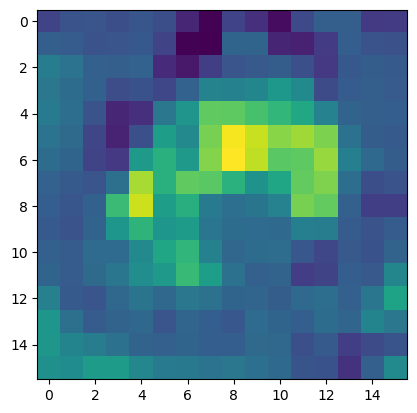

  0%|          | 0/98 [00:00<?, ?it/s]
0it [00:00, ?it/s]

tensor([-0.9499, -0.9511, -0.9531,  0.0453,  0.0370,  0.0368,  0.0403,  0.0421,
         0.9536,  0.9509, -6.3715, -6.4101, -6.5520,  0.0502,  0.0440,  0.0411,
         0.0446,  0.0502,  6.5821,  6.4501, -8.8768, -8.9302, -9.1154,  0.2927,
         0.2705,  0.2635,  0.2737,  0.2922,  9.1669,  8.9837], device='cuda:0')
tensor([0.4939, 0.4939, 0.4941, 0.4907, 0.4908, 0.4909, 0.4909, 0.4908, 0.4941,
        0.4940, 0.4861, 0.4862, 0.4863, 0.4831, 0.4832, 0.4833, 0.4833, 0.4833,
        0.4864, 0.4863, 0.4863, 0.4862, 0.4862, 0.4839, 0.4840, 0.4841, 0.4841,
        0.4841, 0.4864, 0.4864], device='cuda:0')
tensor(10.7233, device='cuda:0')


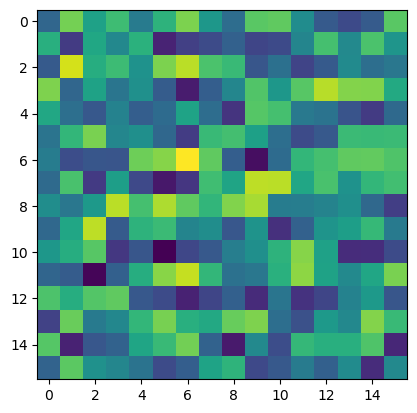

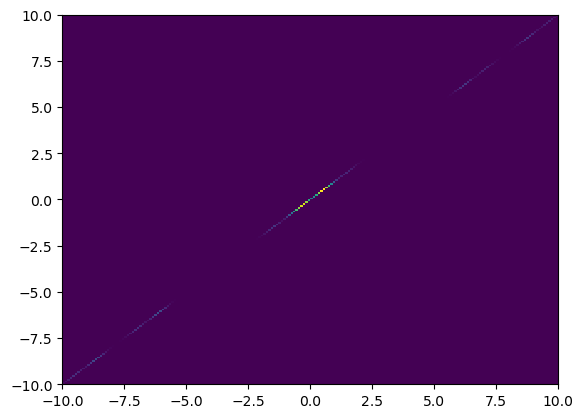

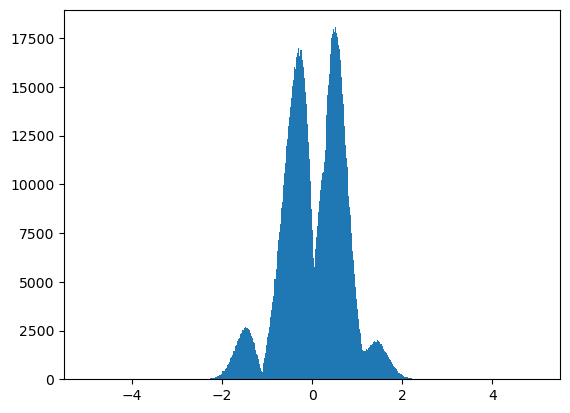

0it [00:00, ?it/s]

building model...


In [9]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_Lfreakformer_small_patch1_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])


ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)


train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=512, shuffle=False, num_workers=0
)

for x, y in tqdm(train_loader):
    plt.imshow(x[0].sum(0).real.cpu().numpy())
    plt.show()
    break

shearlets = shearlets[:]


def shearlet_transform(img):

    return norm(symsqrt(hartley_shearlet_transform(img.to(0), shearlets.to(0), patch_size)))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        512,
        shearlets.shape[0] * 3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.float32, x.dtype
    print(x.real.mean((0, 2, 3)))

    print(x.real.std((0, 2, 3)))

    print(x.real.max())

    plt.imshow(x[0].sum(0).real.cpu().numpy())
    plt.show()
    plt.hist2d(x.flatten().real.cpu().numpy(), x.flatten().real.cpu().numpy(), bins=200, range=[[-10, 10], [-10, 10]])
    plt.show()
    plt.hist(x.flatten().real.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()

    break
print("building model...")


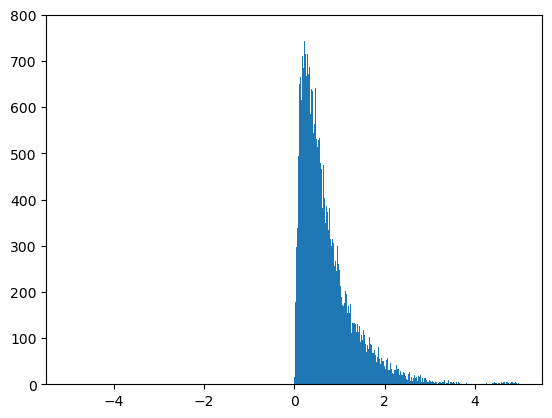

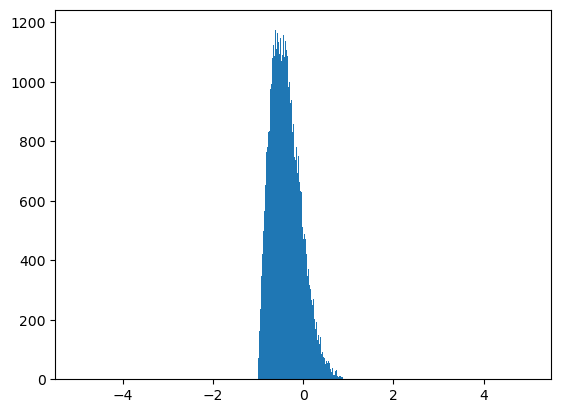

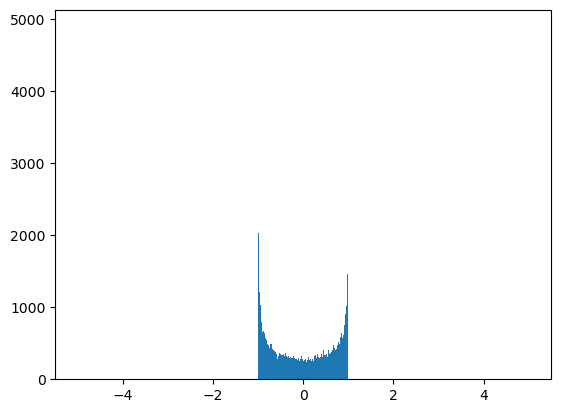

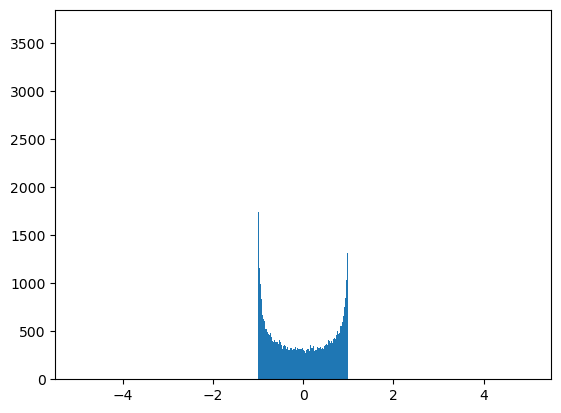

training model...
epoch 0


391it [00:39,  9.86it/s]


epoch 1


391it [00:13, 28.13it/s]


epoch 2


391it [00:13, 28.01it/s]


epoch 3


391it [00:14, 27.71it/s]


epoch 4


391it [00:13, 28.38it/s]


epoch 5


391it [00:14, 27.76it/s]


epoch 6


391it [00:14, 27.69it/s]


epoch 7


391it [00:13, 28.64it/s]



Test set: Avg. loss: 0.0159, Accuracy: 11130/50000 (22%)


Test set: Avg. loss: 0.0160, Accuracy: 2260/10000 (23%)

epoch 8


391it [00:13, 28.03it/s]


epoch 9


391it [00:13, 28.91it/s]


epoch 10


391it [00:13, 28.51it/s]


epoch 11


391it [00:13, 28.06it/s]


epoch 12


391it [00:13, 28.73it/s]


epoch 13


391it [00:13, 28.70it/s]


epoch 14


391it [00:14, 27.63it/s]


epoch 15


391it [00:13, 28.08it/s]



Test set: Avg. loss: 0.0149, Accuracy: 14256/50000 (29%)


Test set: Avg. loss: 0.0148, Accuracy: 2951/10000 (30%)

epoch 16


391it [00:13, 28.70it/s]


epoch 17


391it [00:13, 29.23it/s]


epoch 18


391it [00:13, 28.29it/s]


epoch 19


391it [00:13, 28.19it/s]


epoch 20


391it [00:13, 29.82it/s]


epoch 21


391it [00:13, 28.60it/s]


epoch 22


391it [00:13, 28.99it/s]


epoch 23


391it [00:13, 29.40it/s]



Test set: Avg. loss: 0.0134, Accuracy: 19105/50000 (38%)


Test set: Avg. loss: 0.0131, Accuracy: 3956/10000 (40%)

epoch 24


391it [00:14, 27.74it/s]


epoch 25


391it [00:13, 29.13it/s]


epoch 26


391it [00:13, 28.61it/s]


epoch 27


391it [00:13, 29.65it/s]


epoch 28


391it [00:13, 30.03it/s]


epoch 29


391it [00:13, 28.00it/s]


epoch 30


391it [00:13, 28.66it/s]


epoch 31


391it [00:13, 28.15it/s]



Test set: Avg. loss: 0.0124, Accuracy: 21447/50000 (43%)


Test set: Avg. loss: 0.0121, Accuracy: 4570/10000 (46%)

epoch 32


391it [00:13, 28.59it/s]


epoch 33


391it [00:13, 28.61it/s]


epoch 34


391it [00:13, 29.32it/s]


epoch 35


391it [00:13, 28.78it/s]


epoch 36


391it [00:13, 29.46it/s]


epoch 37


391it [00:12, 30.40it/s]


epoch 38


391it [00:13, 28.87it/s]


epoch 39


391it [00:13, 29.56it/s]



Test set: Avg. loss: 0.0120, Accuracy: 22892/50000 (46%)


Test set: Avg. loss: 0.0118, Accuracy: 4704/10000 (47%)

epoch 40


391it [00:14, 27.91it/s]


epoch 41


391it [00:13, 28.49it/s]


epoch 42


391it [00:13, 28.99it/s]


epoch 43


391it [00:13, 28.04it/s]


epoch 44


391it [00:13, 29.05it/s]


epoch 45


391it [00:13, 28.35it/s]


epoch 46


391it [00:14, 27.59it/s]


epoch 47


391it [00:13, 28.56it/s]



Test set: Avg. loss: 0.0116, Accuracy: 23933/50000 (48%)


Test set: Avg. loss: 0.0112, Accuracy: 4934/10000 (49%)

epoch 48


391it [00:13, 29.15it/s]


epoch 49


391it [00:13, 29.39it/s]


epoch 50


391it [00:13, 29.91it/s]


epoch 51


391it [00:13, 29.68it/s]


epoch 52


391it [00:14, 27.79it/s]


epoch 53


391it [00:14, 27.68it/s]


epoch 54


391it [00:13, 29.00it/s]


epoch 55


391it [00:13, 28.72it/s]



Test set: Avg. loss: 0.0113, Accuracy: 24447/50000 (49%)


Test set: Avg. loss: 0.0108, Accuracy: 5111/10000 (51%)

epoch 56


391it [00:13, 28.66it/s]


epoch 57


391it [00:13, 28.55it/s]


epoch 58


391it [00:12, 31.14it/s]


epoch 59


391it [00:13, 29.03it/s]


epoch 60


391it [00:13, 29.19it/s]


epoch 61


391it [00:13, 28.44it/s]


epoch 62


391it [00:13, 30.00it/s]


epoch 63


391it [00:13, 27.97it/s]



Test set: Avg. loss: 0.0108, Accuracy: 25658/50000 (51%)


Test set: Avg. loss: 0.0105, Accuracy: 5315/10000 (53%)

epoch 64


391it [00:13, 29.02it/s]


epoch 65


391it [00:13, 29.27it/s]


epoch 66


391it [00:13, 28.56it/s]


epoch 67


391it [00:13, 28.76it/s]


epoch 68


391it [00:13, 28.60it/s]


epoch 69


391it [00:13, 29.14it/s]


epoch 70


391it [00:13, 29.78it/s]


epoch 71


391it [00:12, 30.92it/s]



Test set: Avg. loss: 0.0106, Accuracy: 25911/50000 (52%)


Test set: Avg. loss: 0.0103, Accuracy: 5408/10000 (54%)

epoch 72


391it [00:12, 30.59it/s]


epoch 73


391it [00:12, 30.14it/s]


epoch 74


391it [00:13, 27.99it/s]


epoch 75


391it [00:13, 28.29it/s]


epoch 76


391it [00:13, 28.44it/s]


epoch 77


391it [00:14, 27.89it/s]


epoch 78


391it [00:13, 29.00it/s]


epoch 79


391it [00:13, 27.96it/s]



Test set: Avg. loss: 0.0106, Accuracy: 26039/50000 (52%)


Test set: Avg. loss: 0.0103, Accuracy: 5386/10000 (54%)

epoch 80


391it [00:14, 27.80it/s]


epoch 81


391it [00:13, 28.13it/s]


epoch 82


391it [00:13, 28.94it/s]


epoch 83


391it [00:13, 30.02it/s]


epoch 84


391it [00:12, 30.43it/s]


epoch 85


391it [00:12, 30.10it/s]


epoch 86


391it [00:13, 28.72it/s]


epoch 87


391it [00:13, 28.31it/s]



Test set: Avg. loss: 0.0103, Accuracy: 26698/50000 (53%)


Test set: Avg. loss: 0.0100, Accuracy: 5572/10000 (56%)

epoch 88


391it [00:13, 28.78it/s]


epoch 89


391it [00:13, 28.43it/s]


epoch 90


391it [00:13, 28.94it/s]


epoch 91


391it [00:13, 28.37it/s]


epoch 92


391it [00:13, 28.17it/s]


epoch 93


391it [00:14, 27.68it/s]


epoch 94


391it [00:13, 30.05it/s]


epoch 95


391it [00:14, 27.80it/s]



Test set: Avg. loss: 0.0102, Accuracy: 27016/50000 (54%)


Test set: Avg. loss: 0.0099, Accuracy: 5599/10000 (56%)

epoch 96


391it [00:13, 29.37it/s]


epoch 97


391it [00:13, 28.13it/s]


epoch 98


391it [00:14, 27.44it/s]


epoch 99


391it [00:14, 27.77it/s]


epoch 100


391it [00:14, 27.48it/s]


epoch 101


391it [00:13, 28.27it/s]


epoch 102


391it [00:13, 28.77it/s]


epoch 103


391it [00:13, 28.68it/s]



Test set: Avg. loss: 0.0100, Accuracy: 27381/50000 (55%)


Test set: Avg. loss: 0.0098, Accuracy: 5648/10000 (56%)

epoch 104


391it [00:14, 27.54it/s]


epoch 105


391it [00:14, 27.60it/s]


epoch 106


391it [00:13, 28.86it/s]


epoch 107


391it [00:13, 29.57it/s]


epoch 108


391it [00:13, 29.67it/s]


epoch 109


391it [00:14, 26.51it/s]


epoch 110


391it [00:14, 27.83it/s]


epoch 111


391it [00:13, 27.94it/s]



Test set: Avg. loss: 0.0100, Accuracy: 27399/50000 (55%)


Test set: Avg. loss: 0.0097, Accuracy: 5630/10000 (56%)

epoch 112


391it [00:14, 27.81it/s]


epoch 113


391it [00:13, 28.29it/s]


epoch 114


391it [00:13, 28.69it/s]


epoch 115


391it [00:13, 28.79it/s]


epoch 116


391it [00:13, 28.10it/s]


epoch 117


391it [00:14, 27.92it/s]


epoch 118


391it [00:13, 29.11it/s]


epoch 119


391it [00:13, 29.78it/s]



Test set: Avg. loss: 0.0098, Accuracy: 27761/50000 (56%)


Test set: Avg. loss: 0.0095, Accuracy: 5772/10000 (58%)

epoch 120


391it [00:13, 28.23it/s]


epoch 121


391it [00:14, 27.92it/s]


epoch 122


391it [00:13, 28.12it/s]


epoch 123


391it [00:13, 29.15it/s]


epoch 124


391it [00:13, 29.81it/s]


epoch 125


391it [00:13, 29.29it/s]


epoch 126


391it [00:13, 29.24it/s]


epoch 127


391it [00:12, 31.44it/s]



Test set: Avg. loss: 0.0097, Accuracy: 28173/50000 (56%)


Test set: Avg. loss: 0.0094, Accuracy: 5834/10000 (58%)

epoch 128


391it [00:13, 28.88it/s]


epoch 129


391it [00:13, 29.23it/s]


epoch 130


391it [00:13, 29.22it/s]


epoch 131


391it [00:13, 29.65it/s]


epoch 132


391it [00:13, 29.61it/s]


epoch 133


391it [00:13, 29.10it/s]


epoch 134


391it [00:13, 29.15it/s]


epoch 135


391it [00:13, 28.98it/s]



Test set: Avg. loss: 0.0095, Accuracy: 28611/50000 (57%)


Test set: Avg. loss: 0.0092, Accuracy: 5895/10000 (59%)

epoch 136


391it [00:13, 29.11it/s]


epoch 137


391it [00:13, 29.67it/s]


epoch 138


391it [00:13, 28.97it/s]


epoch 139


391it [00:13, 29.78it/s]


epoch 140


391it [00:12, 32.49it/s]


epoch 141


391it [00:13, 29.07it/s]


epoch 142


391it [00:13, 29.55it/s]


epoch 143


391it [00:13, 29.07it/s]



Test set: Avg. loss: 0.0094, Accuracy: 28670/50000 (57%)


Test set: Avg. loss: 0.0092, Accuracy: 5882/10000 (59%)

epoch 144


391it [00:13, 28.21it/s]


epoch 145


391it [00:14, 27.85it/s]


epoch 146


391it [00:13, 27.94it/s]


epoch 147


391it [00:13, 28.84it/s]


epoch 148


391it [00:13, 29.33it/s]


epoch 149


391it [00:13, 28.55it/s]


epoch 150


391it [00:13, 28.60it/s]


epoch 151


391it [00:13, 29.71it/s]



Test set: Avg. loss: 0.0095, Accuracy: 28506/50000 (57%)


Test set: Avg. loss: 0.0092, Accuracy: 5903/10000 (59%)

epoch 152


391it [00:13, 28.46it/s]


epoch 153


391it [00:13, 28.68it/s]


epoch 154


391it [00:13, 28.04it/s]


epoch 155


391it [00:14, 27.67it/s]


epoch 156


391it [00:14, 27.89it/s]


epoch 157


391it [00:13, 28.52it/s]


epoch 158


391it [00:13, 28.67it/s]


epoch 159


391it [00:13, 28.73it/s]



Test set: Avg. loss: 0.0092, Accuracy: 29113/50000 (58%)


Test set: Avg. loss: 0.0091, Accuracy: 5929/10000 (59%)

epoch 160


391it [00:13, 28.48it/s]


epoch 161


391it [00:14, 27.91it/s]


epoch 162


391it [00:14, 27.72it/s]


epoch 163


391it [00:14, 27.60it/s]


epoch 164


391it [00:13, 29.82it/s]


epoch 165


391it [00:12, 31.46it/s]


epoch 166


391it [00:12, 30.26it/s]


epoch 167


391it [00:13, 29.14it/s]



Test set: Avg. loss: 0.0092, Accuracy: 29248/50000 (58%)


Test set: Avg. loss: 0.0090, Accuracy: 5993/10000 (60%)

epoch 168


391it [00:13, 29.58it/s]


epoch 169


391it [00:13, 28.87it/s]


epoch 170


391it [00:13, 29.92it/s]


epoch 171


391it [00:13, 28.60it/s]


epoch 172


391it [00:13, 29.01it/s]


epoch 173


391it [00:13, 29.96it/s]


epoch 174


391it [00:13, 28.19it/s]


epoch 175


391it [00:13, 29.44it/s]



Test set: Avg. loss: 0.0091, Accuracy: 29187/50000 (58%)


Test set: Avg. loss: 0.0089, Accuracy: 6028/10000 (60%)

epoch 176


391it [00:13, 28.77it/s]


epoch 177


391it [00:13, 28.19it/s]


epoch 178


391it [00:13, 28.84it/s]


epoch 179


391it [00:13, 28.50it/s]


epoch 180


391it [00:13, 28.37it/s]


epoch 181


391it [00:12, 30.74it/s]


epoch 182


391it [00:13, 28.19it/s]


epoch 183


391it [00:13, 29.61it/s]



Test set: Avg. loss: 0.0092, Accuracy: 29273/50000 (59%)


Test set: Avg. loss: 0.0089, Accuracy: 5994/10000 (60%)

epoch 184


391it [00:12, 31.07it/s]


epoch 185


391it [00:13, 29.03it/s]


epoch 186


391it [00:13, 28.55it/s]


epoch 187


391it [00:13, 28.90it/s]


epoch 188


391it [00:13, 28.65it/s]


epoch 189


391it [00:13, 29.18it/s]


epoch 190


391it [00:14, 27.72it/s]


epoch 191


391it [00:13, 28.08it/s]



Test set: Avg. loss: 0.0090, Accuracy: 29556/50000 (59%)


Test set: Avg. loss: 0.0088, Accuracy: 6062/10000 (61%)

epoch 192


391it [00:13, 28.08it/s]


epoch 193


391it [00:13, 28.17it/s]


epoch 194


391it [00:13, 29.47it/s]


epoch 195


391it [00:13, 28.59it/s]


epoch 196


391it [00:13, 30.05it/s]


epoch 197


391it [00:13, 28.17it/s]


epoch 198


391it [00:13, 30.00it/s]


epoch 199


391it [00:12, 30.21it/s]



Test set: Avg. loss: 0.0090, Accuracy: 29501/50000 (59%)


Test set: Avg. loss: 0.0088, Accuracy: 6047/10000 (60%)

epoch 200


391it [00:12, 30.43it/s]


epoch 201


391it [00:13, 29.40it/s]


epoch 202


391it [00:13, 28.46it/s]


epoch 203


391it [00:13, 29.51it/s]


epoch 204


391it [00:13, 29.44it/s]


epoch 205


391it [00:12, 30.11it/s]


epoch 206


391it [00:13, 28.40it/s]


epoch 207


391it [00:13, 29.90it/s]



Test set: Avg. loss: 0.0089, Accuracy: 29668/50000 (59%)


Test set: Avg. loss: 0.0088, Accuracy: 6076/10000 (61%)

epoch 208


391it [00:13, 28.35it/s]


epoch 209


391it [00:13, 28.22it/s]


epoch 210


391it [00:12, 30.15it/s]


epoch 211


391it [00:13, 30.01it/s]


epoch 212


391it [00:12, 30.23it/s]


epoch 213


391it [00:13, 28.60it/s]


epoch 214


391it [00:13, 28.71it/s]


epoch 215


391it [00:13, 28.53it/s]



Test set: Avg. loss: 0.0090, Accuracy: 29736/50000 (59%)


Test set: Avg. loss: 0.0088, Accuracy: 6075/10000 (61%)

epoch 216


391it [00:13, 28.42it/s]


epoch 217


391it [00:14, 27.73it/s]


epoch 218


391it [00:12, 30.30it/s]


epoch 219


391it [00:13, 29.42it/s]


epoch 220


391it [00:13, 29.35it/s]


epoch 221


391it [00:13, 28.73it/s]


epoch 222


391it [00:13, 29.38it/s]


epoch 223


391it [00:14, 27.78it/s]



Test set: Avg. loss: 0.0090, Accuracy: 29669/50000 (59%)


Test set: Avg. loss: 0.0087, Accuracy: 6088/10000 (61%)

epoch 224


391it [00:13, 29.07it/s]


epoch 225


391it [00:13, 29.02it/s]


epoch 226


391it [00:12, 30.40it/s]


epoch 227


391it [00:14, 27.81it/s]


epoch 228


391it [00:12, 30.28it/s]


epoch 229


391it [00:13, 29.69it/s]


epoch 230


391it [00:13, 29.35it/s]


epoch 231


391it [00:13, 28.93it/s]



Test set: Avg. loss: 0.0089, Accuracy: 29719/50000 (59%)


Test set: Avg. loss: 0.0087, Accuracy: 6073/10000 (61%)

epoch 232


391it [00:13, 28.07it/s]


epoch 233


391it [00:13, 29.47it/s]


epoch 234


391it [00:13, 28.26it/s]


epoch 235


391it [00:13, 29.28it/s]


epoch 236


391it [00:13, 29.62it/s]


epoch 237


391it [00:13, 28.10it/s]


epoch 238


391it [00:13, 29.20it/s]


epoch 239


391it [00:13, 29.43it/s]



Test set: Avg. loss: 0.0089, Accuracy: 29747/50000 (59%)


Test set: Avg. loss: 0.0087, Accuracy: 6080/10000 (61%)



In [13]:
from shearletNN.deit import deit_tiny_patch2_LS
from shearletNN.deit import vit_models, Layer_scale_init_Block
from shearletNN.shearlet_utils import fourier_pooling_transform
import torchaudio

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)


def pooling_transform(img):
    img = fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.angle(img)
    mag = torch.sqrt((img.real**2) + (img.imag**2))
    mag = symlog(torch.abs(img))
    # mag = torch.abs(img)
    return mag


train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

a_max = None
a_min = None

for x, y in train_loader:
    # this should be the max elementwise and pixelwise as different ones are likely to have different ranges
    a_max = torch.maximum(
        torch.max(x, dim=0)[0], a_max if a_max is not None else torch.max(x, dim=0)[0]
    )
    a_min = torch.minimum(
        torch.min(x, dim=0)[0], a_min if a_min is not None else torch.min(x, dim=0)[0]
    )
else:
    plt.hist(x.flatten().real.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()

a_max, a_min = a_max.unsqueeze(0), a_min.unsqueeze(0)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)


def pooling_transform(img):
    img = fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.angle(img)
    mag = torch.sqrt((img.real**2) + (img.imag**2))

    phase = phase.nan_to_num()
    mag = (2 * (symlog(mag) - a_min) / (a_max - a_min)) - 1
    # mag = (2*(mag - a_min) / (a_max - a_min)) - 1
    # img = torch.cat((mag, torch.cos(phase), torch.cos(phase - (torch.math.pi / 2))), 1)

    k = 1

    img = torch.cat(
        [mag]
        + [torch.cos(phase - ((i * torch.pi) / k)) for i in range(k)]
        + [torch.sin(phase - ((i * torch.pi) / k)) for i in range(k)],
        1,
    )
    # img = torch.cat([mag, phase / torch.math.pi] + [torch.cos(phase - ((i*torch.pi) / k)) for i in range(k)], 1)

    return img


train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

torch.set_float32_matmul_precision("high")

for x, y in train_loader:
    plt.hist(
        x[:, : x.shape[1] // 3].flatten().real.cpu().numpy(), bins=1023, range=[-5, 5]
    )
    plt.show()
    plt.hist(
        x[:, x.shape[1] // 3 : 2 * x.shape[1] // 3].flatten().real.cpu().numpy(),
        bins=1023,
        range=[-5, 5],
    )
    plt.show()
    plt.hist(
        x[:, 2 * x.shape[1] // 3 :].flatten().real.cpu().numpy(),
        bins=1023,
        range=[-5, 5],
    )
    plt.show()
    break

model = vit_models(
    in_chans=x.shape[1],
    img_size=patch_size,
    embed_dim=192,
    num_heads=6,
    depth=12,
    mlp_ratio=4,
    patch_size=2,
    qkv_bias=True,
    block_layers=Layer_scale_init_Block,
    norm_layer=torch.nn.Identity,
    drop_path_rate=0.3,
    drop_rate=0.10,
    attn_drop_rate=0.1,
)
model = torch.compile(model)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

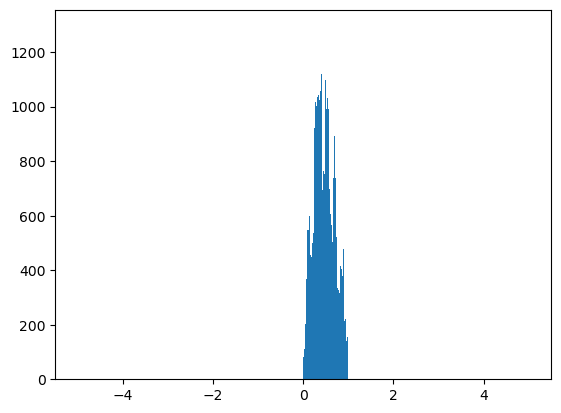

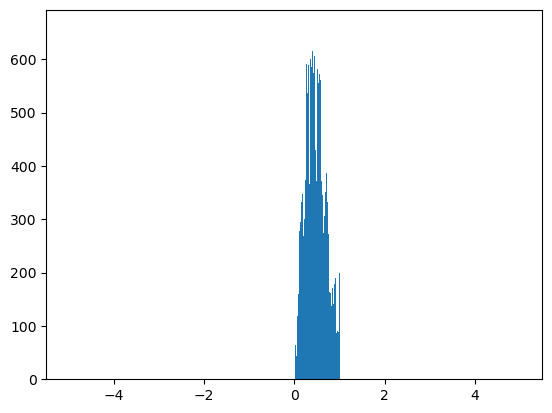

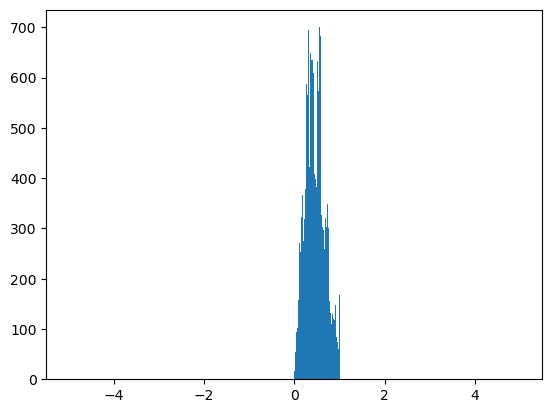

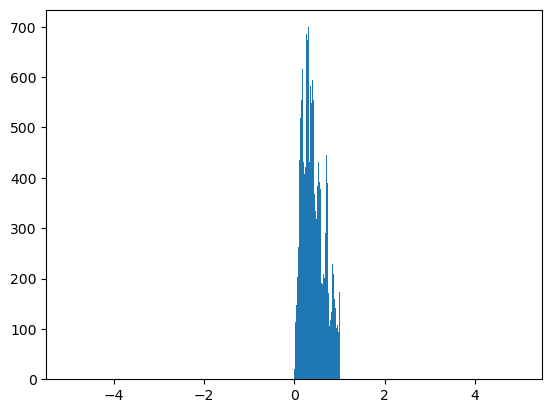

training model...
epoch 0


391it [00:27, 14.47it/s]


epoch 1


391it [00:12, 31.22it/s]


epoch 2


391it [00:12, 31.18it/s]


epoch 3


391it [00:12, 30.56it/s]


epoch 4


391it [00:12, 30.76it/s]


epoch 5


391it [00:12, 30.95it/s]


epoch 6


391it [00:12, 31.44it/s]


epoch 7


391it [00:12, 32.34it/s]



Test set: Avg. loss: 0.0090, Accuracy: 29052/50000 (58%)


Test set: Avg. loss: 0.0091, Accuracy: 5823/10000 (58%)

epoch 8


391it [00:12, 32.00it/s]


epoch 9


391it [00:12, 32.28it/s]


epoch 10


391it [00:11, 33.69it/s]


epoch 11


391it [00:11, 32.65it/s]


epoch 12


391it [00:12, 31.15it/s]


epoch 13


391it [00:12, 31.66it/s]


epoch 14


391it [00:12, 30.68it/s]


epoch 15


391it [00:12, 31.60it/s]



Test set: Avg. loss: 0.0072, Accuracy: 33769/50000 (68%)


Test set: Avg. loss: 0.0077, Accuracy: 6572/10000 (66%)

epoch 16


391it [00:12, 32.23it/s]


epoch 17


391it [00:12, 31.75it/s]


epoch 18


391it [00:12, 32.48it/s]


epoch 19


391it [00:11, 33.44it/s]


epoch 20


391it [00:11, 33.06it/s]


epoch 21


391it [00:11, 33.01it/s]


epoch 22


391it [00:12, 31.96it/s]


epoch 23


391it [00:12, 31.25it/s]



Test set: Avg. loss: 0.0061, Accuracy: 36192/50000 (72%)


Test set: Avg. loss: 0.0066, Accuracy: 7015/10000 (70%)

epoch 24


391it [00:12, 32.56it/s]


epoch 25


391it [00:11, 32.98it/s]


epoch 26


391it [00:11, 33.26it/s]


epoch 27


391it [00:12, 32.11it/s]


epoch 28


391it [00:11, 33.32it/s]


epoch 29


391it [00:12, 32.51it/s]


epoch 30


391it [00:11, 34.61it/s]


epoch 31


391it [00:11, 34.09it/s]



Test set: Avg. loss: 0.0055, Accuracy: 37745/50000 (75%)


Test set: Avg. loss: 0.0063, Accuracy: 7180/10000 (72%)

epoch 32


391it [00:11, 34.18it/s]


epoch 33


391it [00:12, 32.14it/s]


epoch 34


391it [00:12, 32.47it/s]


epoch 35


391it [00:12, 31.52it/s]


epoch 36


391it [00:12, 32.10it/s]


epoch 37


391it [00:12, 32.15it/s]


epoch 38


391it [00:12, 32.16it/s]


epoch 39


391it [00:12, 30.94it/s]



Test set: Avg. loss: 0.0048, Accuracy: 39315/50000 (79%)


Test set: Avg. loss: 0.0060, Accuracy: 7376/10000 (74%)

epoch 40


391it [00:12, 31.23it/s]


epoch 41


391it [00:11, 32.88it/s]


epoch 42


391it [00:12, 30.75it/s]


epoch 43


391it [00:12, 31.86it/s]


epoch 44


391it [00:12, 31.24it/s]


epoch 45


391it [00:12, 32.44it/s]


epoch 46


391it [00:12, 31.09it/s]


epoch 47


391it [00:12, 31.69it/s]



Test set: Avg. loss: 0.0044, Accuracy: 40039/50000 (80%)


Test set: Avg. loss: 0.0059, Accuracy: 7410/10000 (74%)

epoch 48


391it [00:12, 31.26it/s]


epoch 49


391it [00:12, 32.44it/s]


epoch 50


391it [00:12, 32.34it/s]


epoch 51


391it [00:12, 32.23it/s]


epoch 52


391it [00:12, 32.24it/s]


epoch 53


391it [00:12, 31.81it/s]


epoch 54


391it [00:12, 32.32it/s]


epoch 55


391it [00:12, 31.48it/s]



Test set: Avg. loss: 0.0039, Accuracy: 41179/50000 (82%)


Test set: Avg. loss: 0.0057, Accuracy: 7495/10000 (75%)

epoch 56


391it [00:12, 31.68it/s]


epoch 57


391it [00:12, 32.30it/s]


epoch 58


391it [00:12, 32.23it/s]


epoch 59


391it [00:12, 32.08it/s]


epoch 60


391it [00:12, 31.70it/s]


epoch 61


391it [00:11, 32.62it/s]


epoch 62


391it [00:12, 30.84it/s]


epoch 63


391it [00:11, 33.17it/s]



Test set: Avg. loss: 0.0034, Accuracy: 42315/50000 (85%)


Test set: Avg. loss: 0.0055, Accuracy: 7608/10000 (76%)

epoch 64


391it [00:12, 32.56it/s]


epoch 65


391it [00:12, 32.36it/s]


epoch 66


391it [00:11, 33.50it/s]


epoch 67


391it [00:12, 31.94it/s]


epoch 68


391it [00:12, 32.01it/s]


epoch 69


391it [00:12, 31.58it/s]


epoch 70


391it [00:12, 32.21it/s]


epoch 71


391it [00:11, 32.80it/s]



Test set: Avg. loss: 0.0031, Accuracy: 42880/50000 (86%)


Test set: Avg. loss: 0.0055, Accuracy: 7684/10000 (77%)

epoch 72


391it [00:12, 31.44it/s]


epoch 73


391it [00:12, 32.01it/s]


epoch 74


391it [00:11, 33.04it/s]


epoch 75


391it [00:11, 33.69it/s]


epoch 76


391it [00:12, 31.54it/s]


epoch 77


391it [00:11, 32.85it/s]


epoch 78


391it [00:11, 32.73it/s]


epoch 79


391it [00:12, 32.49it/s]



Test set: Avg. loss: 0.0027, Accuracy: 43958/50000 (88%)


Test set: Avg. loss: 0.0053, Accuracy: 7743/10000 (77%)

epoch 80


391it [00:11, 33.47it/s]


epoch 81


391it [00:11, 33.29it/s]


epoch 82


391it [00:11, 34.53it/s]


epoch 83


391it [00:11, 33.76it/s]


epoch 84


391it [00:11, 33.69it/s]


epoch 85


391it [00:12, 31.98it/s]


epoch 86


391it [00:11, 33.11it/s]


epoch 87


391it [00:11, 32.98it/s]



Test set: Avg. loss: 0.0024, Accuracy: 44715/50000 (89%)


Test set: Avg. loss: 0.0054, Accuracy: 7806/10000 (78%)

epoch 88


391it [00:11, 33.42it/s]


epoch 89


391it [00:11, 33.17it/s]


epoch 90


391it [00:11, 33.03it/s]


epoch 91


391it [00:11, 33.25it/s]


epoch 92


391it [00:11, 33.40it/s]


epoch 93


391it [00:12, 32.29it/s]


epoch 94


391it [00:11, 32.70it/s]


epoch 95


391it [00:11, 32.75it/s]



Test set: Avg. loss: 0.0021, Accuracy: 45292/50000 (91%)


Test set: Avg. loss: 0.0054, Accuracy: 7814/10000 (78%)

epoch 96


391it [00:11, 33.16it/s]


epoch 97


391it [00:11, 33.70it/s]


epoch 98


391it [00:12, 31.97it/s]


epoch 99


391it [00:12, 32.29it/s]


epoch 100


391it [00:11, 33.25it/s]


epoch 101


391it [00:11, 33.83it/s]


epoch 102


391it [00:11, 34.36it/s]


epoch 103


391it [00:11, 32.60it/s]



Test set: Avg. loss: 0.0019, Accuracy: 45840/50000 (92%)


Test set: Avg. loss: 0.0055, Accuracy: 7838/10000 (78%)

epoch 104


391it [00:11, 32.63it/s]


epoch 105


391it [00:11, 33.82it/s]


epoch 106


391it [00:11, 33.74it/s]


epoch 107


391it [00:11, 33.48it/s]


epoch 108


391it [00:11, 34.15it/s]


epoch 109


391it [00:11, 33.20it/s]


epoch 110


391it [00:11, 32.72it/s]


epoch 111


391it [00:11, 32.74it/s]



Test set: Avg. loss: 0.0017, Accuracy: 46419/50000 (93%)


Test set: Avg. loss: 0.0055, Accuracy: 7798/10000 (78%)

epoch 112


391it [00:11, 33.18it/s]


epoch 113


391it [00:12, 32.34it/s]


epoch 114


391it [00:11, 33.37it/s]


epoch 115


391it [00:11, 33.48it/s]


epoch 116


391it [00:11, 32.86it/s]


epoch 117


391it [00:12, 32.21it/s]


epoch 118


391it [00:11, 33.13it/s]


epoch 119


391it [00:11, 33.00it/s]



Test set: Avg. loss: 0.0014, Accuracy: 47038/50000 (94%)


Test set: Avg. loss: 0.0056, Accuracy: 7887/10000 (79%)

epoch 120


391it [00:11, 32.74it/s]


epoch 121


391it [00:11, 32.96it/s]


epoch 122


391it [00:11, 33.22it/s]


epoch 123


391it [00:11, 32.92it/s]


epoch 124


391it [00:11, 33.11it/s]


epoch 125


391it [00:11, 34.11it/s]


epoch 126


391it [00:11, 34.18it/s]


epoch 127


391it [00:11, 33.34it/s]



Test set: Avg. loss: 0.0012, Accuracy: 47312/50000 (95%)


Test set: Avg. loss: 0.0056, Accuracy: 7853/10000 (79%)

epoch 128


391it [00:11, 33.10it/s]


epoch 129


391it [00:11, 33.40it/s]


epoch 130


391it [00:12, 32.51it/s]


epoch 131


391it [00:11, 32.78it/s]


epoch 132


391it [00:11, 34.57it/s]


epoch 133


391it [00:12, 32.15it/s]


epoch 134


391it [00:11, 32.82it/s]


epoch 135


391it [00:12, 32.22it/s]



Test set: Avg. loss: 0.0011, Accuracy: 47679/50000 (95%)


Test set: Avg. loss: 0.0058, Accuracy: 7894/10000 (79%)

epoch 136


391it [00:12, 32.19it/s]


epoch 137


391it [00:12, 32.56it/s]


epoch 138


391it [00:11, 33.33it/s]


epoch 139


391it [00:11, 33.17it/s]


epoch 140


391it [00:12, 32.49it/s]


epoch 141


391it [00:11, 33.14it/s]


epoch 142


391it [00:11, 34.21it/s]


epoch 143


391it [00:11, 33.12it/s]



Test set: Avg. loss: 0.0010, Accuracy: 47978/50000 (96%)


Test set: Avg. loss: 0.0058, Accuracy: 7908/10000 (79%)

epoch 144


391it [00:11, 32.69it/s]


epoch 145


391it [00:11, 33.31it/s]


epoch 146


391it [00:11, 33.78it/s]


epoch 147


391it [00:11, 32.78it/s]


epoch 148


391it [00:11, 33.41it/s]


epoch 149


391it [00:11, 34.49it/s]


epoch 150


391it [00:11, 33.70it/s]


epoch 151


391it [00:11, 33.23it/s]



Test set: Avg. loss: 0.0008, Accuracy: 48275/50000 (97%)


Test set: Avg. loss: 0.0058, Accuracy: 7911/10000 (79%)

epoch 152


391it [00:11, 32.70it/s]


epoch 153


391it [00:11, 34.60it/s]


epoch 154


391it [00:12, 32.35it/s]


epoch 155


391it [00:12, 31.58it/s]


epoch 156


391it [00:12, 32.05it/s]


epoch 157


391it [00:11, 32.66it/s]


epoch 158


391it [00:11, 33.85it/s]


epoch 159


391it [00:12, 31.90it/s]



Test set: Avg. loss: 0.0007, Accuracy: 48507/50000 (97%)


Test set: Avg. loss: 0.0060, Accuracy: 7891/10000 (79%)

epoch 160


391it [00:12, 32.03it/s]


epoch 161


391it [00:11, 33.11it/s]


epoch 162


391it [00:12, 31.75it/s]


epoch 163


391it [00:12, 32.57it/s]


epoch 164


391it [00:12, 32.48it/s]


epoch 165


391it [00:11, 33.69it/s]


epoch 166


391it [00:11, 33.24it/s]


epoch 167


391it [00:12, 31.56it/s]



Test set: Avg. loss: 0.0007, Accuracy: 48590/50000 (97%)


Test set: Avg. loss: 0.0062, Accuracy: 7941/10000 (79%)

epoch 168


391it [00:12, 32.56it/s]


epoch 169


391it [00:12, 32.38it/s]


epoch 170


391it [00:12, 30.91it/s]


epoch 171


391it [00:12, 32.07it/s]


epoch 172


391it [00:12, 32.24it/s]


epoch 173


391it [00:12, 30.52it/s]


epoch 174


391it [00:12, 32.48it/s]


epoch 175


391it [00:11, 32.64it/s]



Test set: Avg. loss: 0.0006, Accuracy: 48749/50000 (97%)


Test set: Avg. loss: 0.0060, Accuracy: 7997/10000 (80%)

epoch 176


391it [00:11, 32.74it/s]


epoch 177


391it [00:12, 32.58it/s]


epoch 178


391it [00:11, 32.87it/s]


epoch 179


391it [00:11, 32.59it/s]


epoch 180


391it [00:12, 32.12it/s]


epoch 181


391it [00:12, 32.08it/s]


epoch 182


391it [00:11, 32.92it/s]


epoch 183


391it [00:12, 32.27it/s]



Test set: Avg. loss: 0.0005, Accuracy: 48927/50000 (98%)


Test set: Avg. loss: 0.0061, Accuracy: 7992/10000 (80%)

epoch 184


391it [00:11, 33.08it/s]


epoch 185


391it [00:11, 33.23it/s]


epoch 186


391it [00:11, 33.32it/s]


epoch 187


391it [00:12, 31.62it/s]


epoch 188


391it [00:11, 32.77it/s]


epoch 189


391it [00:12, 32.34it/s]


epoch 190


391it [00:12, 32.53it/s]


epoch 191


391it [00:12, 30.90it/s]



Test set: Avg. loss: 0.0005, Accuracy: 48992/50000 (98%)


Test set: Avg. loss: 0.0063, Accuracy: 7991/10000 (80%)

epoch 192


391it [00:11, 32.74it/s]


epoch 193


391it [00:11, 32.69it/s]


epoch 194


391it [00:11, 32.90it/s]


epoch 195


391it [00:12, 32.44it/s]


epoch 196


391it [00:11, 34.46it/s]


epoch 197


391it [00:11, 33.21it/s]


epoch 198


391it [00:11, 32.87it/s]


epoch 199


391it [00:11, 32.86it/s]



Test set: Avg. loss: 0.0005, Accuracy: 49088/50000 (98%)


Test set: Avg. loss: 0.0064, Accuracy: 7987/10000 (80%)

epoch 200


391it [00:11, 33.37it/s]


epoch 201


391it [00:11, 33.17it/s]


epoch 202


391it [00:11, 33.12it/s]


epoch 203


391it [00:11, 33.01it/s]


epoch 204


391it [00:11, 33.67it/s]


epoch 205


391it [00:11, 32.88it/s]


epoch 206


391it [00:11, 32.78it/s]


epoch 207


391it [00:12, 32.38it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49209/50000 (98%)


Test set: Avg. loss: 0.0064, Accuracy: 8018/10000 (80%)

epoch 208


391it [00:11, 32.90it/s]


epoch 209


391it [00:11, 33.79it/s]


epoch 210


391it [00:12, 32.52it/s]


epoch 211


391it [00:11, 32.90it/s]


epoch 212


391it [00:11, 32.70it/s]


epoch 213


391it [00:12, 32.24it/s]


epoch 214


391it [00:11, 33.31it/s]


epoch 215


391it [00:11, 32.67it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49186/50000 (98%)


Test set: Avg. loss: 0.0064, Accuracy: 8017/10000 (80%)

epoch 216


391it [00:11, 33.58it/s]


epoch 217


391it [00:12, 31.78it/s]


epoch 218


391it [00:11, 32.98it/s]


epoch 219


391it [00:12, 32.09it/s]


epoch 220


391it [00:12, 32.31it/s]


epoch 221


391it [00:12, 32.11it/s]


epoch 222


391it [00:12, 31.33it/s]


epoch 223


391it [00:12, 31.86it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49210/50000 (98%)


Test set: Avg. loss: 0.0065, Accuracy: 8009/10000 (80%)

epoch 224


391it [00:11, 33.01it/s]


epoch 225


391it [00:12, 32.57it/s]


epoch 226


391it [00:11, 32.87it/s]


epoch 227


391it [00:12, 31.51it/s]


epoch 228


391it [00:11, 32.93it/s]


epoch 229


391it [00:11, 33.95it/s]


epoch 230


391it [00:11, 32.81it/s]


epoch 231


391it [00:11, 33.31it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49156/50000 (98%)


Test set: Avg. loss: 0.0065, Accuracy: 8015/10000 (80%)

epoch 232


391it [00:12, 32.52it/s]


epoch 233


391it [00:12, 32.47it/s]


epoch 234


391it [00:11, 33.22it/s]


epoch 235


391it [00:11, 34.24it/s]


epoch 236


391it [00:12, 32.10it/s]


epoch 237


391it [00:12, 32.56it/s]


epoch 238


391it [00:12, 31.40it/s]


epoch 239


391it [00:11, 33.85it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49201/50000 (98%)


Test set: Avg. loss: 0.0065, Accuracy: 8017/10000 (80%)



In [14]:
from shearletNN.deit import deit_tiny_patch2_LS
from shearletNN.deit import vit_models, Layer_scale_init_Block
from shearletNN.shearlet_utils import image_fourier_pooling_transform
import torchaudio

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)


def pooling_transform(img):
    img = image_fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    return img
    phase = torch.angle(img)
    mag = torch.sqrt((img.real**2) + (img.imag**2))
    mag = symlog(torch.abs(img))
    # mag = torch.abs(img)
    return mag


train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

a_max = None
a_min = None

for x, y in train_loader:
    # this should be the max elementwise and pixelwise as different ones are likely to have different ranges
    a_max = torch.maximum(
        torch.max(x, dim=0)[0], a_max if a_max is not None else torch.max(x, dim=0)[0]
    )
    a_min = torch.minimum(
        torch.min(x, dim=0)[0], a_min if a_min is not None else torch.min(x, dim=0)[0]
    )
else:
    plt.hist(x.flatten().real.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()

a_max, a_min = a_max.unsqueeze(0), a_min.unsqueeze(0)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

"""
def pooling_transform(img):
    img = image_fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.angle(img)
    mag = torch.sqrt((img.real**2) + (img.imag**2))

    phase = phase.nan_to_num()
    mag = (2 * (symlog(mag) - a_min) / (a_max - a_min)) - 1
    # mag = (2*(mag - a_min) / (a_max - a_min)) - 1
    # img = torch.cat((mag, torch.cos(phase), torch.cos(phase - (torch.math.pi / 2))), 1)

    k = 1

    img = torch.cat(
        [mag]
        + [torch.cos(phase - ((i * torch.pi) / k)) for i in range(k)]
        + [torch.sin(phase - ((i * torch.pi) / k)) for i in range(k)],
        1,
    )
    # img = torch.cat([mag, phase / torch.math.pi] + [torch.cos(phase - ((i*torch.pi) / k)) for i in range(k)], 1)

    return img
"""

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

torch.set_float32_matmul_precision("high")

for x, y in train_loader:
    plt.hist(
        x[:, : x.shape[1] // 3].flatten().real.cpu().numpy(), bins=1023, range=[-5, 5]
    )
    plt.show()
    plt.hist(
        x[:, x.shape[1] // 3 : 2 * x.shape[1] // 3].flatten().real.cpu().numpy(),
        bins=1023,
        range=[-5, 5],
    )
    plt.show()
    plt.hist(
        x[:, 2 * x.shape[1] // 3 :].flatten().real.cpu().numpy(),
        bins=1023,
        range=[-5, 5],
    )
    plt.show()
    break

model = vit_models(
    in_chans=x.shape[1],
    img_size=patch_size,
    embed_dim=192,
    num_heads=6,
    depth=12,
    mlp_ratio=4,
    patch_size=2,
    qkv_bias=True,
    block_layers=Layer_scale_init_Block,
    drop_path_rate=0.25,
    drop_rate=0.1,
    attn_drop_rate=0.1,
)
model = torch.compile(model)

# model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

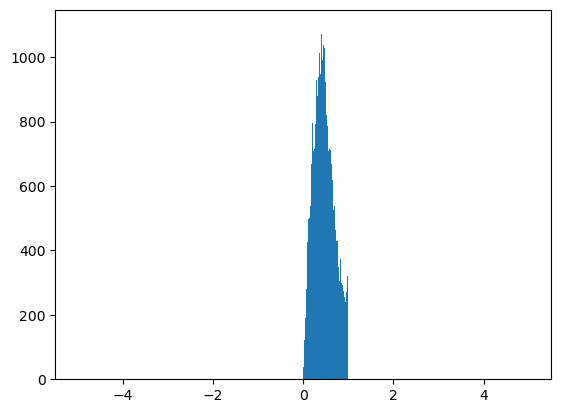

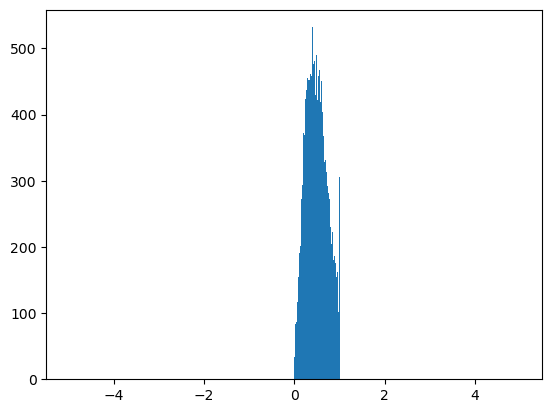

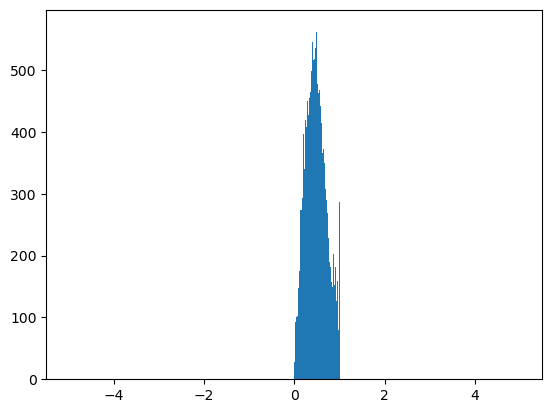

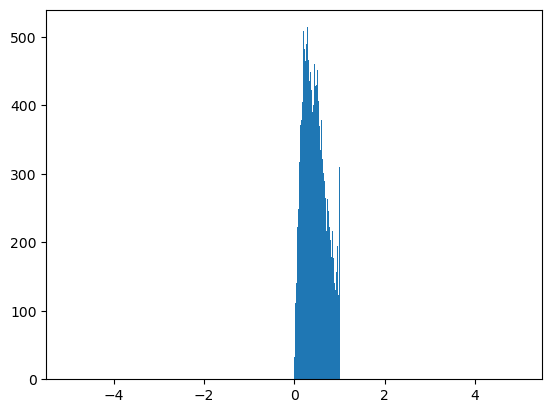

training model...
epoch 0


391it [00:33, 11.61it/s]


epoch 1


391it [00:14, 27.86it/s]


epoch 2


391it [00:14, 27.22it/s]


epoch 3


391it [00:13, 28.13it/s]


epoch 4


391it [00:13, 27.97it/s]


epoch 5


391it [00:15, 25.39it/s]


epoch 6


391it [00:15, 25.98it/s]


epoch 7


391it [00:15, 25.75it/s]



Test set: Avg. loss: 0.0086, Accuracy: 30535/50000 (61%)


Test set: Avg. loss: 0.0086, Accuracy: 6057/10000 (61%)

epoch 8


391it [00:13, 28.84it/s]


epoch 9


391it [00:14, 27.14it/s]


epoch 10


391it [00:14, 27.52it/s]


epoch 11


391it [00:13, 28.49it/s]


epoch 12


391it [00:14, 27.73it/s]


epoch 13


391it [00:14, 26.99it/s]


epoch 14


391it [00:14, 26.23it/s]


epoch 15


391it [00:14, 27.10it/s]



Test set: Avg. loss: 0.0073, Accuracy: 33379/50000 (67%)


Test set: Avg. loss: 0.0076, Accuracy: 6532/10000 (65%)

epoch 16


391it [00:14, 27.16it/s]


epoch 17


391it [00:14, 27.73it/s]


epoch 18


391it [00:14, 26.51it/s]


epoch 19


391it [00:15, 25.62it/s]


epoch 20


391it [00:14, 26.94it/s]


epoch 21


391it [00:14, 27.20it/s]


epoch 22


391it [00:14, 27.67it/s]


epoch 23


391it [00:13, 27.95it/s]



Test set: Avg. loss: 0.0063, Accuracy: 35873/50000 (72%)


Test set: Avg. loss: 0.0069, Accuracy: 6911/10000 (69%)

epoch 24


391it [00:14, 27.93it/s]


epoch 25


391it [00:13, 28.43it/s]


epoch 26


391it [00:14, 27.74it/s]


epoch 27


391it [00:13, 28.15it/s]


epoch 28


391it [00:13, 28.61it/s]


epoch 29


391it [00:14, 27.38it/s]


epoch 30


391it [00:13, 28.26it/s]


epoch 31


391it [00:14, 27.72it/s]



Test set: Avg. loss: 0.0057, Accuracy: 37241/50000 (74%)


Test set: Avg. loss: 0.0065, Accuracy: 7081/10000 (71%)

epoch 32


391it [00:14, 27.21it/s]


epoch 33


391it [00:14, 27.35it/s]


epoch 34


391it [00:13, 28.24it/s]


epoch 35


391it [00:13, 28.39it/s]


epoch 36


391it [00:14, 27.20it/s]


epoch 37


391it [00:14, 27.08it/s]


epoch 38


391it [00:13, 28.66it/s]


epoch 39


391it [00:14, 27.52it/s]



Test set: Avg. loss: 0.0050, Accuracy: 38770/50000 (78%)


Test set: Avg. loss: 0.0061, Accuracy: 7266/10000 (73%)

epoch 40


391it [00:14, 27.82it/s]


epoch 41


391it [00:14, 27.83it/s]


epoch 42


391it [00:13, 28.05it/s]


epoch 43


391it [00:14, 27.34it/s]


epoch 44


391it [00:14, 27.51it/s]


epoch 45


391it [00:13, 28.53it/s]


epoch 46


391it [00:13, 28.16it/s]


epoch 47


391it [00:13, 28.47it/s]



Test set: Avg. loss: 0.0045, Accuracy: 39741/50000 (79%)


Test set: Avg. loss: 0.0060, Accuracy: 7323/10000 (73%)

epoch 48


391it [00:13, 28.67it/s]


epoch 49


391it [00:13, 28.43it/s]


epoch 50


391it [00:13, 28.39it/s]


epoch 51


391it [00:13, 28.43it/s]


epoch 52


391it [00:13, 29.21it/s]


epoch 53


391it [00:13, 29.50it/s]


epoch 54


391it [00:13, 28.74it/s]


epoch 55


391it [00:14, 27.80it/s]



Test set: Avg. loss: 0.0039, Accuracy: 41176/50000 (82%)


Test set: Avg. loss: 0.0057, Accuracy: 7510/10000 (75%)

epoch 56


391it [00:13, 28.30it/s]


epoch 57


391it [00:13, 28.24it/s]


epoch 58


391it [00:14, 26.77it/s]


epoch 59


391it [00:13, 28.01it/s]


epoch 60


391it [00:13, 28.13it/s]


epoch 61


391it [00:13, 28.20it/s]


epoch 62


391it [00:13, 28.80it/s]


epoch 63


391it [00:13, 28.43it/s]



Test set: Avg. loss: 0.0035, Accuracy: 42251/50000 (85%)


Test set: Avg. loss: 0.0056, Accuracy: 7544/10000 (75%)

epoch 64


391it [00:13, 28.08it/s]


epoch 65


391it [00:13, 28.44it/s]


epoch 66


391it [00:14, 27.45it/s]


epoch 67


391it [00:14, 27.50it/s]


epoch 68


391it [00:13, 28.68it/s]


epoch 69


391it [00:13, 29.10it/s]


epoch 70


391it [00:13, 28.50it/s]


epoch 71


391it [00:13, 28.47it/s]



Test set: Avg. loss: 0.0031, Accuracy: 43123/50000 (86%)


Test set: Avg. loss: 0.0055, Accuracy: 7610/10000 (76%)

epoch 72


391it [00:14, 27.35it/s]


epoch 73


391it [00:13, 28.66it/s]


epoch 74


391it [00:13, 28.17it/s]


epoch 75


391it [00:13, 28.13it/s]


epoch 76


391it [00:14, 27.62it/s]


epoch 77


391it [00:14, 26.86it/s]


epoch 78


391it [00:13, 28.15it/s]


epoch 79


391it [00:14, 27.46it/s]



Test set: Avg. loss: 0.0027, Accuracy: 44063/50000 (88%)


Test set: Avg. loss: 0.0055, Accuracy: 7721/10000 (77%)

epoch 80


391it [00:14, 27.53it/s]


epoch 81


391it [00:14, 27.39it/s]


epoch 82


391it [00:14, 26.52it/s]


epoch 83


391it [00:13, 28.53it/s]


epoch 84


391it [00:13, 29.26it/s]


epoch 85


391it [00:13, 28.73it/s]


epoch 86


391it [00:13, 28.93it/s]


epoch 87


391it [00:13, 29.23it/s]



Test set: Avg. loss: 0.0025, Accuracy: 44586/50000 (89%)


Test set: Avg. loss: 0.0054, Accuracy: 7740/10000 (77%)

epoch 88


391it [00:14, 27.91it/s]


epoch 89


391it [00:13, 28.02it/s]


epoch 90


391it [00:14, 27.73it/s]


epoch 91


391it [00:13, 28.15it/s]


epoch 92


391it [00:13, 28.78it/s]


epoch 93


391it [00:14, 27.72it/s]


epoch 94


391it [00:14, 27.12it/s]


epoch 95


391it [00:14, 27.60it/s]



Test set: Avg. loss: 0.0021, Accuracy: 45432/50000 (91%)


Test set: Avg. loss: 0.0054, Accuracy: 7743/10000 (77%)

epoch 96


391it [00:14, 26.90it/s]


epoch 97


391it [00:13, 28.61it/s]


epoch 98


391it [00:13, 29.20it/s]


epoch 99


391it [00:13, 27.93it/s]


epoch 100


391it [00:13, 28.32it/s]


epoch 101


391it [00:13, 28.13it/s]


epoch 102


391it [00:13, 28.06it/s]


epoch 103


391it [00:14, 26.36it/s]



Test set: Avg. loss: 0.0019, Accuracy: 45975/50000 (92%)


Test set: Avg. loss: 0.0055, Accuracy: 7779/10000 (78%)

epoch 104


391it [00:14, 27.71it/s]


epoch 105


391it [00:14, 27.18it/s]


epoch 106


391it [00:14, 26.76it/s]


epoch 107


391it [00:14, 27.30it/s]


epoch 108


391it [00:14, 27.30it/s]


epoch 109


391it [00:14, 27.26it/s]


epoch 110


391it [00:14, 27.05it/s]


epoch 111


391it [00:14, 27.50it/s]



Test set: Avg. loss: 0.0017, Accuracy: 46399/50000 (93%)


Test set: Avg. loss: 0.0055, Accuracy: 7862/10000 (79%)

epoch 112


391it [00:13, 28.18it/s]


epoch 113


391it [00:13, 28.01it/s]


epoch 114


391it [00:14, 27.16it/s]


epoch 115


391it [00:14, 27.55it/s]


epoch 116


391it [00:13, 29.23it/s]


epoch 117


391it [00:13, 28.72it/s]


epoch 118


391it [00:13, 28.49it/s]


epoch 119


391it [00:13, 28.04it/s]



Test set: Avg. loss: 0.0014, Accuracy: 47001/50000 (94%)


Test set: Avg. loss: 0.0058, Accuracy: 7806/10000 (78%)

epoch 120


391it [00:13, 28.64it/s]


epoch 121


391it [00:13, 28.75it/s]


epoch 122


391it [00:13, 29.20it/s]


epoch 123


391it [00:13, 29.19it/s]


epoch 124


391it [00:13, 27.97it/s]


epoch 125


391it [00:15, 25.97it/s]


epoch 126


391it [00:15, 25.66it/s]


epoch 127


391it [00:13, 28.61it/s]



Test set: Avg. loss: 0.0013, Accuracy: 47274/50000 (95%)


Test set: Avg. loss: 0.0057, Accuracy: 7848/10000 (78%)

epoch 128


391it [00:14, 27.88it/s]


epoch 129


391it [00:13, 27.97it/s]


epoch 130


391it [00:14, 27.24it/s]


epoch 131


391it [00:14, 27.82it/s]


epoch 132


391it [00:14, 27.46it/s]


epoch 133


391it [00:14, 27.36it/s]


epoch 134


391it [00:14, 27.35it/s]


epoch 135


391it [00:14, 27.62it/s]



Test set: Avg. loss: 0.0011, Accuracy: 47644/50000 (95%)


Test set: Avg. loss: 0.0060, Accuracy: 7865/10000 (79%)

epoch 136


391it [00:14, 26.79it/s]


epoch 137


391it [00:15, 26.00it/s]


epoch 138


391it [00:14, 27.53it/s]


epoch 139


391it [00:13, 28.65it/s]


epoch 140


391it [00:13, 28.20it/s]


epoch 141


391it [00:14, 26.95it/s]


epoch 142


391it [00:14, 27.51it/s]


epoch 143


391it [00:14, 27.75it/s]



Test set: Avg. loss: 0.0010, Accuracy: 48024/50000 (96%)


Test set: Avg. loss: 0.0058, Accuracy: 7880/10000 (79%)

epoch 144


391it [00:14, 27.27it/s]


epoch 145


391it [00:14, 26.68it/s]


epoch 146


391it [00:14, 27.26it/s]


epoch 147


391it [00:14, 26.93it/s]


epoch 148


391it [00:14, 27.31it/s]


epoch 149


391it [00:14, 27.71it/s]


epoch 150


391it [00:14, 26.77it/s]


epoch 151


391it [00:14, 27.17it/s]



Test set: Avg. loss: 0.0009, Accuracy: 48203/50000 (96%)


Test set: Avg. loss: 0.0060, Accuracy: 7910/10000 (79%)

epoch 152


391it [00:14, 26.55it/s]


epoch 153


391it [00:14, 27.06it/s]


epoch 154


391it [00:14, 27.35it/s]


epoch 155


391it [00:14, 27.87it/s]


epoch 156


391it [00:13, 28.44it/s]


epoch 157


391it [00:13, 28.74it/s]


epoch 158


391it [00:14, 27.65it/s]


epoch 159


391it [00:14, 26.78it/s]



Test set: Avg. loss: 0.0007, Accuracy: 48557/50000 (97%)


Test set: Avg. loss: 0.0061, Accuracy: 7922/10000 (79%)

epoch 160


391it [00:14, 27.63it/s]


epoch 161


391it [00:14, 27.54it/s]


epoch 162


391it [00:14, 26.98it/s]


epoch 163


391it [00:14, 27.08it/s]


epoch 164


391it [00:14, 26.92it/s]


epoch 165


391it [00:14, 26.95it/s]


epoch 166


391it [00:14, 26.64it/s]


epoch 167


391it [00:13, 28.15it/s]



Test set: Avg. loss: 0.0006, Accuracy: 48669/50000 (97%)


Test set: Avg. loss: 0.0061, Accuracy: 7947/10000 (79%)

epoch 168


391it [00:13, 28.39it/s]


epoch 169


391it [00:13, 28.68it/s]


epoch 170


391it [00:14, 27.89it/s]


epoch 171


391it [00:14, 26.49it/s]


epoch 172


391it [00:14, 26.16it/s]


epoch 173


391it [00:15, 25.95it/s]


epoch 174


391it [00:13, 28.74it/s]


epoch 175


391it [00:13, 29.22it/s]



Test set: Avg. loss: 0.0006, Accuracy: 48728/50000 (97%)


Test set: Avg. loss: 0.0063, Accuracy: 7902/10000 (79%)

epoch 176


391it [00:13, 28.45it/s]


epoch 177


391it [00:13, 29.17it/s]


epoch 178


391it [00:13, 28.25it/s]


epoch 179


391it [00:13, 29.08it/s]


epoch 180


391it [00:13, 28.89it/s]


epoch 181


391it [00:13, 29.59it/s]


epoch 182


391it [00:13, 29.55it/s]


epoch 183


391it [00:13, 28.19it/s]



Test set: Avg. loss: 0.0005, Accuracy: 48959/50000 (98%)


Test set: Avg. loss: 0.0064, Accuracy: 7911/10000 (79%)

epoch 184


391it [00:14, 27.87it/s]


epoch 185


391it [00:13, 28.93it/s]


epoch 186


391it [00:13, 28.62it/s]


epoch 187


391it [00:14, 27.62it/s]


epoch 188


391it [00:14, 27.72it/s]


epoch 189


391it [00:14, 27.24it/s]


epoch 190


391it [00:14, 27.21it/s]


epoch 191


391it [00:14, 27.24it/s]



Test set: Avg. loss: 0.0005, Accuracy: 48976/50000 (98%)


Test set: Avg. loss: 0.0064, Accuracy: 7931/10000 (79%)

epoch 192


391it [00:14, 26.90it/s]


epoch 193


391it [00:14, 26.85it/s]


epoch 194


391it [00:13, 28.95it/s]


epoch 195


391it [00:13, 30.05it/s]


epoch 196


391it [00:12, 30.32it/s]


epoch 197


391it [00:12, 30.21it/s]


epoch 198


391it [00:12, 30.54it/s]


epoch 199


391it [00:12, 30.34it/s]



Test set: Avg. loss: 0.0005, Accuracy: 49026/50000 (98%)


Test set: Avg. loss: 0.0064, Accuracy: 7940/10000 (79%)

epoch 200


391it [00:13, 29.33it/s]


epoch 201


391it [00:13, 29.65it/s]


epoch 202


391it [00:13, 29.50it/s]


epoch 203


391it [00:13, 29.75it/s]


epoch 204


391it [00:12, 30.34it/s]


epoch 205


391it [00:13, 29.99it/s]


epoch 206


391it [00:13, 30.03it/s]


epoch 207


391it [00:13, 29.32it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49109/50000 (98%)


Test set: Avg. loss: 0.0065, Accuracy: 7920/10000 (79%)

epoch 208


391it [00:13, 28.34it/s]


epoch 209


391it [00:13, 28.68it/s]


epoch 210


391it [00:13, 29.27it/s]


epoch 211


391it [00:13, 28.32it/s]


epoch 212


391it [00:14, 27.18it/s]


epoch 213


391it [00:14, 27.48it/s]


epoch 214


391it [00:14, 27.59it/s]


epoch 215


391it [00:13, 29.33it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49124/50000 (98%)


Test set: Avg. loss: 0.0065, Accuracy: 7944/10000 (79%)

epoch 216


391it [00:13, 28.26it/s]


epoch 217


391it [00:13, 27.95it/s]


epoch 218


391it [00:13, 27.93it/s]


epoch 219


391it [00:14, 26.77it/s]


epoch 220


391it [00:14, 27.06it/s]


epoch 221


391it [00:15, 25.84it/s]


epoch 222


391it [00:15, 24.54it/s]


epoch 223


391it [00:13, 28.26it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49176/50000 (98%)


Test set: Avg. loss: 0.0065, Accuracy: 7958/10000 (80%)

epoch 224


391it [00:14, 27.69it/s]


epoch 225


391it [00:14, 27.32it/s]


epoch 226


391it [00:14, 27.32it/s]


epoch 227


391it [00:13, 28.50it/s]


epoch 228


391it [00:13, 28.54it/s]


epoch 229


391it [00:13, 28.83it/s]


epoch 230


391it [00:13, 28.69it/s]


epoch 231


391it [00:13, 28.66it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49243/50000 (98%)


Test set: Avg. loss: 0.0065, Accuracy: 7955/10000 (80%)

epoch 232


391it [00:14, 27.83it/s]


epoch 233


391it [00:13, 28.45it/s]


epoch 234


391it [00:13, 28.85it/s]


epoch 235


391it [00:13, 28.75it/s]


epoch 236


391it [00:13, 28.81it/s]


epoch 237


391it [00:14, 26.12it/s]


epoch 238


391it [00:13, 28.29it/s]


epoch 239


391it [00:13, 28.27it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49151/50000 (98%)


Test set: Avg. loss: 0.0065, Accuracy: 7956/10000 (80%)



In [ ]:
from shearletNN.deit import deit_tiny_patch2_LS
from shearletNN.deit import vit_models, Layer_scale_init_Block
from shearletNN.shearlet_utils import image_fourier_pooling_transform
import torchaudio

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

pooling_transform = torchvision.transforms.Resize(patch_size)

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

a_max = None
a_min = None

for x, y in train_loader:
    # this should be the max elementwise and pixelwise as different ones are likely to have different ranges
    a_max = torch.maximum(
        torch.max(x, dim=0)[0], a_max if a_max is not None else torch.max(x, dim=0)[0]
    )
    a_min = torch.minimum(
        torch.min(x, dim=0)[0], a_min if a_min is not None else torch.min(x, dim=0)[0]
    )
else:
    plt.hist(x.flatten().real.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()

a_max, a_min = a_max.unsqueeze(0), a_min.unsqueeze(0)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

"""
def pooling_transform(img):
    img = image_fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.angle(img)
    mag = torch.sqrt((img.real**2) + (img.imag**2))

    phase = phase.nan_to_num()
    mag = (2 * (symlog(mag) - a_min) / (a_max - a_min)) - 1
    # mag = (2*(mag - a_min) / (a_max - a_min)) - 1
    # img = torch.cat((mag, torch.cos(phase), torch.cos(phase - (torch.math.pi / 2))), 1)

    k = 1

    img = torch.cat(
        [mag]
        + [torch.cos(phase - ((i * torch.pi) / k)) for i in range(k)]
        + [torch.sin(phase - ((i * torch.pi) / k)) for i in range(k)],
        1,
    )
    # img = torch.cat([mag, phase / torch.math.pi] + [torch.cos(phase - ((i*torch.pi) / k)) for i in range(k)], 1)

    return img
"""

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

torch.set_float32_matmul_precision("high")

for x, y in train_loader:
    assert x.shape[-2] == x.shape[-1] == patch_size
    plt.hist(
        x[:, : x.shape[1] // 3].flatten().real.cpu().numpy(), bins=1023, range=[-5, 5]
    )
    plt.show()
    plt.hist(
        x[:, x.shape[1] // 3 : 2 * x.shape[1] // 3].flatten().real.cpu().numpy(),
        bins=1023,
        range=[-5, 5],
    )
    plt.show()
    plt.hist(
        x[:, 2 * x.shape[1] // 3 :].flatten().real.cpu().numpy(),
        bins=1023,
        range=[-5, 5],
    )
    plt.show()
    break

model = vit_models(
    in_chans=x.shape[1],
    img_size=patch_size,
    embed_dim=192,
    num_heads=6,
    depth=12,
    mlp_ratio=4,
    patch_size=2,
    qkv_bias=True,
    block_layers=Layer_scale_init_Block,
    drop_path_rate=0.25,
    drop_rate=0.1,
    attn_drop_rate=0.1,
)
model = torch.compile(model)

# model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

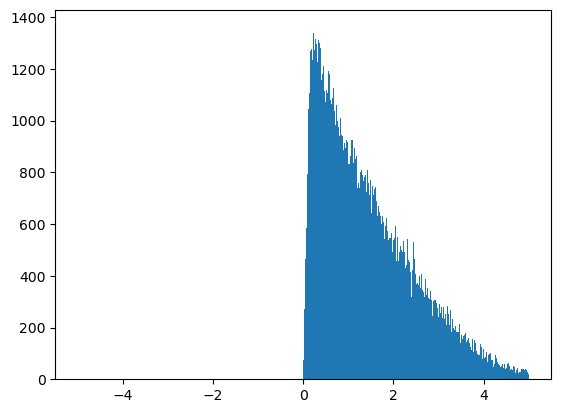

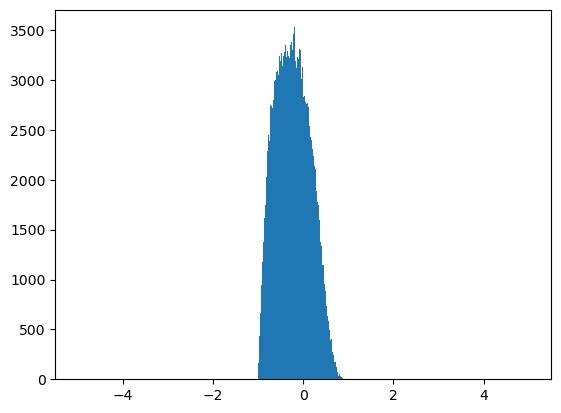

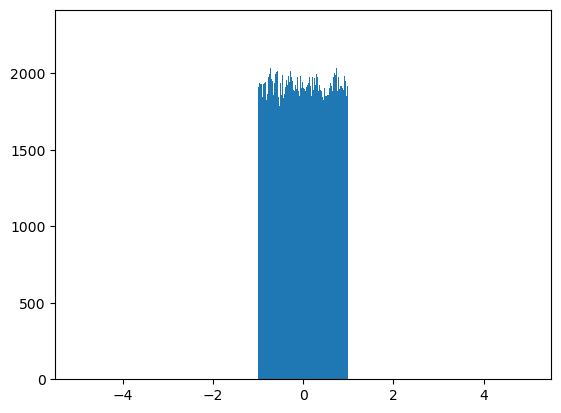

training model...
epoch 0


0it [00:00, ?it/s]


TorchRuntimeError: Failed running call_module L__self___patch_embed_proj(*(FakeTensor(..., device='cuda:0', size=(s0, s1, s2, s3)),), **{}):
Given groups=1, weight of size [192, 24, 2, 2], expected input[s0, s1, s2, s3] to have 24 channels, but got s1 channels instead

from user code:
   File "/home/jroth/shearlet-extraction/shearlet-nn/src/shearletNN/deit.py", line 1156, in forward
    x = self.forward_features(x)
  File "/home/jroth/shearlet-extraction/shearlet-nn/src/shearletNN/deit.py", line 1141, in forward_features
    x = self.patch_embed(x)
  File "/home/jroth/miniforge3/envs/shearlets/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/jroth/miniforge3/envs/shearlets/lib/python3.9/site-packages/timm/layers/patch_embed.py", line 131, in forward
    x = self.proj(x)

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [ ]:
from shearletNN.deit import deit_tiny_patch2_LS
from shearletNN.shearlet_utils import fourier_pooling_transform
import torchaudio

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    img = fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.angle(img)
    mag = torch.sqrt((img.real ** 2) + (img.imag ** 2))
    mag = symlog(torch.abs(img))
    # mag = torch.abs(img)
    return mag

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

a_max = None
a_min = None

for x, y in train_loader:
    # this should be the max elementwise and pixelwise as different ones are likely to have different ranges
    a_max = torch.maximum(torch.max(x, dim=0)[0], a_max if a_max is not None else torch.max(x, dim=0)[0])
    a_min = torch.minimum(torch.min(x, dim=0)[0], a_min if a_min is not None else torch.min(x, dim=0)[0])
else:
    plt.hist(x.flatten().real.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()

a_max, a_min = a_max.unsqueeze(0), a_min.unsqueeze(0)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    img = fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.angle(img) / torch.math.pi
    mag = torch.sqrt((img.real ** 2) + (img.imag ** 2))

    phase = phase.nan_to_num()
    mag = (2*(symlog(mag) - a_min) / (a_max - a_min)) - 1
    # mag = (2*(mag - a_min) / (a_max - a_min)) - 1

    img = torch.cat((mag, phase), 1)

    return img

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

torch.set_float32_matmul_precision('high')

model = deit_tiny_patch2_LS(in_chans=24, img_size=patch_size)
model = torch.compile(model)

# model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

for x, y in train_loader:
    plt.hist(x[:, :x.shape[1] // 2].flatten().real.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()
    plt.hist(x[:, x.shape[1] // 2:].flatten().real.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()
    break

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

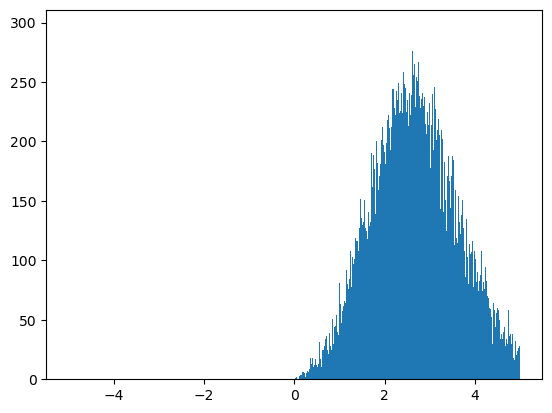

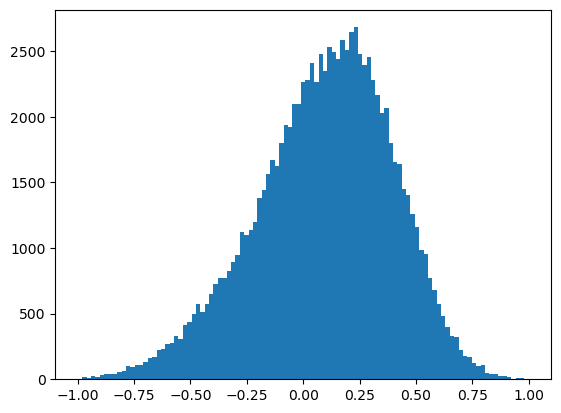

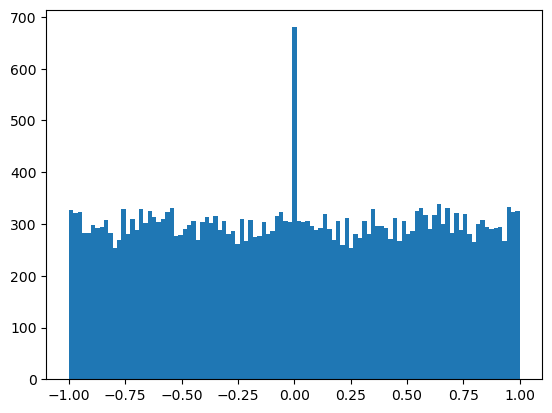

training model...
epoch 0


391it [01:06,  5.89it/s]


epoch 1


391it [00:48,  8.12it/s]


epoch 2


391it [00:48,  8.13it/s]


epoch 3


391it [00:48,  8.12it/s]


epoch 4


391it [00:48,  8.12it/s]


epoch 5


391it [00:48,  8.12it/s]


epoch 6


391it [00:48,  8.12it/s]


epoch 7


391it [00:48,  8.13it/s]



Test set: Avg. loss: 0.0104, Accuracy: 26308/50000 (53%)


Test set: Avg. loss: 0.0104, Accuracy: 5345/10000 (53%)

epoch 8


391it [00:48,  8.14it/s]


epoch 9


391it [00:48,  8.14it/s]


epoch 10


391it [00:48,  8.14it/s]


epoch 11


391it [00:48,  8.13it/s]


epoch 12


391it [00:48,  8.13it/s]


epoch 13


391it [00:48,  8.13it/s]


epoch 14


391it [00:48,  8.13it/s]


epoch 15


391it [00:48,  8.13it/s]



Test set: Avg. loss: 0.0086, Accuracy: 30466/50000 (61%)


Test set: Avg. loss: 0.0088, Accuracy: 6082/10000 (61%)

epoch 16


391it [00:48,  8.13it/s]


epoch 17


391it [00:48,  8.12it/s]


epoch 18


391it [00:48,  8.14it/s]


epoch 19


391it [00:48,  8.14it/s]


epoch 20


391it [00:48,  8.12it/s]


epoch 21


391it [00:48,  8.12it/s]


epoch 22


391it [00:48,  8.13it/s]


epoch 23


391it [00:48,  8.13it/s]



Test set: Avg. loss: 0.0069, Accuracy: 34195/50000 (68%)


Test set: Avg. loss: 0.0077, Accuracy: 6569/10000 (66%)

epoch 24


391it [00:48,  8.13it/s]


epoch 25


391it [00:48,  8.12it/s]


epoch 26


391it [00:48,  8.12it/s]


epoch 27


391it [00:48,  8.11it/s]


epoch 28


391it [00:48,  8.13it/s]


epoch 29


391it [00:48,  8.12it/s]


epoch 30


391it [00:48,  8.13it/s]


epoch 31


391it [00:48,  8.13it/s]



Test set: Avg. loss: 0.0058, Accuracy: 36798/50000 (74%)


Test set: Avg. loss: 0.0074, Accuracy: 6764/10000 (68%)

epoch 32


391it [00:48,  8.13it/s]


epoch 33


391it [00:48,  8.12it/s]


epoch 34


391it [00:48,  8.11it/s]


epoch 35


391it [00:48,  8.12it/s]


epoch 36


391it [00:48,  8.13it/s]


epoch 37


391it [00:48,  8.13it/s]


epoch 38


391it [00:48,  8.15it/s]


epoch 39


391it [00:48,  8.12it/s]



Test set: Avg. loss: 0.0047, Accuracy: 39334/50000 (79%)


Test set: Avg. loss: 0.0078, Accuracy: 6711/10000 (67%)

epoch 40


391it [00:48,  8.13it/s]


epoch 41


391it [00:48,  8.14it/s]


epoch 42


391it [00:48,  8.12it/s]


epoch 43


391it [00:48,  8.12it/s]


epoch 44


391it [00:48,  8.12it/s]


epoch 45


391it [00:48,  8.11it/s]


epoch 46


391it [00:48,  8.12it/s]


epoch 47


391it [00:48,  8.12it/s]



Test set: Avg. loss: 0.0036, Accuracy: 42008/50000 (84%)


Test set: Avg. loss: 0.0076, Accuracy: 6962/10000 (70%)

epoch 48


391it [00:48,  8.13it/s]


epoch 49


391it [00:48,  8.13it/s]


epoch 50


391it [00:48,  8.13it/s]


epoch 51


391it [00:48,  8.12it/s]


epoch 52


391it [00:48,  8.13it/s]


epoch 53


391it [00:48,  8.14it/s]


epoch 54


391it [00:47,  8.15it/s]


epoch 55


391it [00:48,  8.13it/s]



Test set: Avg. loss: 0.0028, Accuracy: 43818/50000 (88%)


Test set: Avg. loss: 0.0084, Accuracy: 7003/10000 (70%)

epoch 56


391it [00:48,  8.13it/s]


epoch 57


391it [00:48,  8.13it/s]


epoch 58


391it [00:48,  8.13it/s]


epoch 59


391it [00:48,  8.13it/s]


epoch 60


391it [00:48,  8.14it/s]


epoch 61


391it [00:48,  8.12it/s]


epoch 62


391it [00:48,  8.11it/s]


epoch 63


391it [00:48,  8.11it/s]



Test set: Avg. loss: 0.0025, Accuracy: 44568/50000 (89%)


Test set: Avg. loss: 0.0094, Accuracy: 6870/10000 (69%)

epoch 64


391it [00:48,  8.13it/s]


epoch 65


391it [00:48,  8.13it/s]


epoch 66


391it [00:48,  8.12it/s]


epoch 67


391it [00:48,  8.13it/s]


epoch 68


391it [00:48,  8.14it/s]


epoch 69


391it [00:48,  8.12it/s]


epoch 70


391it [00:48,  8.10it/s]


epoch 71


391it [00:48,  8.12it/s]



Test set: Avg. loss: 0.0019, Accuracy: 45770/50000 (92%)


Test set: Avg. loss: 0.0100, Accuracy: 7024/10000 (70%)

epoch 72


391it [00:48,  8.13it/s]


epoch 73


391it [00:48,  8.12it/s]


epoch 74


391it [00:48,  8.13it/s]


epoch 75


391it [00:48,  8.12it/s]


epoch 76


391it [00:48,  8.12it/s]


epoch 77


391it [00:48,  8.14it/s]


epoch 78


391it [00:48,  8.12it/s]


epoch 79


391it [00:48,  8.13it/s]



Test set: Avg. loss: 0.0016, Accuracy: 46421/50000 (93%)


Test set: Avg. loss: 0.0106, Accuracy: 6955/10000 (70%)

epoch 80


391it [00:48,  8.12it/s]


epoch 81


391it [00:48,  8.09it/s]


epoch 82


391it [00:48,  8.15it/s]


epoch 83


391it [00:48,  8.11it/s]


epoch 84


391it [00:48,  8.13it/s]


epoch 85


391it [00:48,  8.13it/s]


epoch 86


391it [00:48,  8.13it/s]


epoch 87


391it [00:48,  8.12it/s]



Test set: Avg. loss: 0.0014, Accuracy: 46887/50000 (94%)


Test set: Avg. loss: 0.0104, Accuracy: 6992/10000 (70%)

epoch 88


391it [00:48,  8.12it/s]


epoch 89


391it [00:48,  8.14it/s]


epoch 90


391it [00:48,  8.13it/s]


epoch 91


391it [00:48,  8.13it/s]


epoch 92


391it [00:48,  8.13it/s]


epoch 93


391it [00:48,  8.13it/s]


epoch 94


391it [00:48,  8.13it/s]


epoch 95


391it [00:48,  8.12it/s]



Test set: Avg. loss: 0.0012, Accuracy: 47523/50000 (95%)


Test set: Avg. loss: 0.0113, Accuracy: 7037/10000 (70%)

epoch 96


391it [00:48,  8.12it/s]


epoch 97


391it [00:48,  8.13it/s]


epoch 98


391it [00:48,  8.13it/s]


epoch 99


391it [00:48,  8.12it/s]


epoch 100


391it [00:48,  8.13it/s]


epoch 101


391it [00:48,  8.13it/s]


epoch 102


391it [00:48,  8.11it/s]


epoch 103


391it [00:48,  8.12it/s]



Test set: Avg. loss: 0.0010, Accuracy: 47866/50000 (96%)


Test set: Avg. loss: 0.0110, Accuracy: 7033/10000 (70%)

epoch 104


391it [00:48,  8.12it/s]


epoch 105


391it [00:48,  8.12it/s]


epoch 106


391it [00:48,  8.13it/s]


epoch 107


391it [00:48,  8.11it/s]


epoch 108


391it [00:48,  8.06it/s]


epoch 109


391it [00:48,  8.08it/s]


epoch 110


391it [00:48,  8.08it/s]


epoch 111


391it [00:48,  8.08it/s]



Test set: Avg. loss: 0.0009, Accuracy: 48013/50000 (96%)


Test set: Avg. loss: 0.0116, Accuracy: 7019/10000 (70%)

epoch 112


391it [00:48,  8.09it/s]


epoch 113


391it [00:48,  8.10it/s]


epoch 114


391it [00:48,  8.10it/s]


epoch 115


391it [00:48,  8.10it/s]


epoch 116


391it [00:48,  8.08it/s]


epoch 117


391it [00:48,  8.09it/s]


epoch 118


391it [00:48,  8.11it/s]


epoch 119


391it [00:48,  8.10it/s]



Test set: Avg. loss: 0.0007, Accuracy: 48408/50000 (97%)


Test set: Avg. loss: 0.0116, Accuracy: 7065/10000 (71%)

epoch 120


391it [00:48,  8.09it/s]


epoch 121


391it [00:48,  8.11it/s]


epoch 122


391it [00:48,  8.10it/s]


epoch 123


391it [00:48,  8.10it/s]


epoch 124


391it [00:48,  8.10it/s]


epoch 125


391it [00:48,  8.10it/s]


epoch 126


391it [00:48,  8.11it/s]


epoch 127


391it [00:48,  8.09it/s]



Test set: Avg. loss: 0.0007, Accuracy: 48518/50000 (97%)


Test set: Avg. loss: 0.0118, Accuracy: 7067/10000 (71%)

epoch 128


391it [00:48,  8.08it/s]


epoch 129


391it [00:48,  8.08it/s]


epoch 130


391it [00:48,  8.09it/s]


epoch 131


391it [00:48,  8.07it/s]


epoch 132


391it [00:48,  8.08it/s]


epoch 133


391it [00:48,  8.07it/s]


epoch 134


391it [00:48,  8.08it/s]


epoch 135


391it [00:48,  8.08it/s]



Test set: Avg. loss: 0.0006, Accuracy: 48732/50000 (97%)


Test set: Avg. loss: 0.0126, Accuracy: 7058/10000 (71%)

epoch 136


391it [00:48,  8.08it/s]


epoch 137


391it [00:48,  8.08it/s]


epoch 138


391it [00:48,  8.08it/s]


epoch 139


391it [00:48,  8.09it/s]


epoch 140


391it [00:48,  8.09it/s]


epoch 141


391it [00:48,  8.02it/s]


epoch 142


391it [00:48,  8.08it/s]


epoch 143


391it [00:48,  8.10it/s]



Test set: Avg. loss: 0.0005, Accuracy: 48927/50000 (98%)


Test set: Avg. loss: 0.0132, Accuracy: 7012/10000 (70%)

epoch 144


391it [00:48,  8.08it/s]


epoch 145


391it [00:48,  8.07it/s]


epoch 146


391it [00:48,  8.09it/s]


epoch 147


391it [00:48,  8.09it/s]


epoch 148


391it [00:48,  8.08it/s]


epoch 149


391it [00:48,  8.08it/s]


epoch 150


391it [00:48,  8.08it/s]


epoch 151


391it [00:48,  8.09it/s]



Test set: Avg. loss: 0.0005, Accuracy: 49014/50000 (98%)


Test set: Avg. loss: 0.0129, Accuracy: 7072/10000 (71%)

epoch 152


391it [00:48,  8.11it/s]


epoch 153


391it [00:48,  8.13it/s]


epoch 154


391it [00:48,  8.12it/s]


epoch 155


391it [00:48,  8.11it/s]


epoch 156


391it [00:48,  8.09it/s]


epoch 157


391it [00:48,  8.10it/s]


epoch 158


391it [00:48,  8.09it/s]


epoch 159


391it [00:48,  8.09it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49204/50000 (98%)


Test set: Avg. loss: 0.0129, Accuracy: 7099/10000 (71%)

epoch 160


391it [00:48,  8.10it/s]


epoch 161


391it [00:48,  8.09it/s]


epoch 162


391it [00:48,  8.08it/s]


epoch 163


391it [00:48,  8.07it/s]


epoch 164


391it [00:48,  8.09it/s]


epoch 165


391it [00:48,  8.08it/s]


epoch 166


391it [00:48,  8.08it/s]


epoch 167


391it [00:48,  8.07it/s]



Test set: Avg. loss: 0.0004, Accuracy: 49266/50000 (99%)


Test set: Avg. loss: 0.0138, Accuracy: 7101/10000 (71%)

epoch 168


391it [00:48,  8.09it/s]


epoch 169


391it [00:48,  8.12it/s]


epoch 170


391it [00:48,  8.13it/s]


epoch 171


391it [00:48,  8.12it/s]


epoch 172


391it [00:48,  8.13it/s]


epoch 173


391it [00:48,  8.13it/s]


epoch 174


391it [00:48,  8.08it/s]


epoch 175


391it [00:48,  8.10it/s]



Test set: Avg. loss: 0.0003, Accuracy: 49362/50000 (99%)


Test set: Avg. loss: 0.0138, Accuracy: 7113/10000 (71%)

epoch 176


391it [00:48,  8.09it/s]


epoch 177


391it [00:48,  8.08it/s]


epoch 178


391it [00:48,  8.09it/s]


epoch 179


391it [00:48,  8.11it/s]


epoch 180


391it [00:48,  8.11it/s]


epoch 181


391it [00:48,  8.12it/s]


epoch 182


391it [00:48,  8.11it/s]


epoch 183


391it [00:48,  8.12it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49491/50000 (99%)


Test set: Avg. loss: 0.0137, Accuracy: 7140/10000 (71%)

epoch 184


391it [00:48,  8.12it/s]


epoch 185


391it [00:48,  8.10it/s]


epoch 186


391it [00:48,  8.07it/s]


epoch 187


391it [00:48,  8.08it/s]


epoch 188


391it [00:48,  8.07it/s]


epoch 189


391it [00:48,  8.08it/s]


epoch 190


391it [00:48,  8.08it/s]


epoch 191


391it [00:48,  8.09it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49529/50000 (99%)


Test set: Avg. loss: 0.0141, Accuracy: 7156/10000 (72%)

epoch 192


391it [00:48,  8.08it/s]


epoch 193


391it [00:48,  8.10it/s]


epoch 194


391it [00:48,  8.09it/s]


epoch 195


391it [00:48,  8.11it/s]


epoch 196


391it [00:48,  8.12it/s]


epoch 197


391it [00:48,  8.13it/s]


epoch 198


391it [00:48,  8.13it/s]


epoch 199


391it [00:48,  8.13it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49592/50000 (99%)


Test set: Avg. loss: 0.0141, Accuracy: 7163/10000 (72%)

epoch 200


391it [00:48,  8.13it/s]


epoch 201


391it [00:48,  8.11it/s]


epoch 202


391it [00:48,  8.13it/s]


epoch 203


391it [00:48,  8.13it/s]


epoch 204


391it [00:48,  8.12it/s]


epoch 205


391it [00:48,  8.13it/s]


epoch 206


391it [00:48,  8.11it/s]


epoch 207


391it [00:48,  8.12it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49600/50000 (99%)


Test set: Avg. loss: 0.0141, Accuracy: 7154/10000 (72%)

epoch 208


391it [00:48,  8.12it/s]


epoch 209


391it [00:48,  8.06it/s]


epoch 210


391it [00:48,  8.15it/s]


epoch 211


391it [00:48,  8.12it/s]


epoch 212


391it [00:48,  8.13it/s]


epoch 213


391it [00:48,  8.13it/s]


epoch 214


391it [00:48,  8.13it/s]


epoch 215


391it [00:48,  8.12it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49684/50000 (99%)


Test set: Avg. loss: 0.0141, Accuracy: 7168/10000 (72%)

epoch 216


391it [00:48,  8.13it/s]


epoch 217


391it [00:48,  8.12it/s]


epoch 218


391it [00:48,  8.12it/s]


epoch 219


391it [00:48,  8.12it/s]


epoch 220


391it [00:48,  8.12it/s]


epoch 221


391it [00:48,  8.11it/s]


epoch 222


391it [00:48,  8.11it/s]


epoch 223


391it [00:48,  8.12it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49698/50000 (99%)


Test set: Avg. loss: 0.0141, Accuracy: 7174/10000 (72%)

epoch 224


391it [00:48,  8.11it/s]


epoch 225


391it [00:48,  8.12it/s]


epoch 226


391it [00:48,  8.12it/s]


epoch 227


391it [00:48,  8.11it/s]


epoch 228


391it [00:48,  8.11it/s]


epoch 229


391it [00:48,  8.11it/s]


epoch 230


391it [00:48,  8.11it/s]


epoch 231


391it [00:48,  8.11it/s]



Test set: Avg. loss: 0.0001, Accuracy: 49703/50000 (99%)


Test set: Avg. loss: 0.0142, Accuracy: 7187/10000 (72%)

epoch 232


391it [00:48,  8.10it/s]


epoch 233


391it [00:48,  8.11it/s]


epoch 234


391it [00:48,  8.11it/s]


epoch 235


391it [00:48,  8.11it/s]


epoch 236


391it [00:48,  8.11it/s]


epoch 237


391it [00:48,  8.10it/s]


epoch 238


391it [00:48,  8.10it/s]


epoch 239


391it [00:48,  8.08it/s]



Test set: Avg. loss: 0.0002, Accuracy: 49665/50000 (99%)


Test set: Avg. loss: 0.0142, Accuracy: 7180/10000 (72%)



In [ ]:
from shearletNN.deit import deit_tiny_patch1_LS
from shearletNN.shearlet_utils import fourier_pooling_transform
import torchaudio

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    img = fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.angle(img)
    mag = torch.sqrt((img.real ** 2) + (img.imag ** 2))
    mag = symlog(torch.abs(img))
    return mag

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

a_max = None
a_min = None

for x, y in train_loader:
    # this should be the max elementwise and pixelwise as different ones are likely to have different ranges
    a_max = torch.maximum(torch.max(x, dim=0)[0], a_max if a_max is not None else torch.max(x, dim=0)[0])
    a_min = torch.minimum(torch.min(x, dim=0)[0], a_min if a_min is not None else torch.min(x, dim=0)[0])
else:
    plt.hist(x.flatten().real.cpu().numpy(), bins=1023, range=[-5, 5])
    plt.show()

a_max, a_min = a_max.unsqueeze(0), a_min.unsqueeze(0)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    img = fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.angle(img)
    mag = torch.sqrt((img.real ** 2) + (img.imag ** 2))

    phase = phase.nan_to_num()
    mag = (2*(symlog(mag) - a_min) / (a_max - a_min)) - 1

    img = torch.cat((mag, phase), 1)

    return img

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

torch.set_float32_matmul_precision('high')

model = torch.nn.Sequential(torch.nn.Conv2d(6, 24, 3, 1, 'same'), deit_tiny_patch1_LS(in_chans=24, img_size=patch_size))
model = torch.compile(model)

# model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

for x, y in train_loader:
    plt.hist(x[:, :x.shape[1] // 2].flatten().real.cpu().numpy(), bins=103, range=[-1, 1])
    plt.show()
    plt.hist(x[:, x.shape[1] // 2:].flatten().real.cpu().numpy(), bins=103, range=[-1, 1])
    plt.show()
    break

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

In [ ]:
from shearletNN.deit import deit_tiny_patch2_LS
from shearletNN.shearlet_utils import fourier_pooling_transform

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    img = fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.tanh(img.real / img.imag) / torch.math.pi
    phase = phase.nan_to_num()
    mag = torch.abs(img) 

    img = torch.cat((mag, phase), 1)

    return img

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

a_max = 0
a_min = 0

for x, y in train_loader:
    a_max = max(x[:, :x.shape[1] // 2].max(), a_max)
    a_min = min(x[:, :x.shape[1] // 2].min(), a_min)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    img = fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)
    phase = torch.tanh(img.real / img.imag) / torch.math.pi
    phase = phase.nan_to_num()
    mag = (2*(torch.abs(img) - a_min) / (a_max - a_min)) - 1

    img = torch.cat((mag, phase), 1)

    return img

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

model = complex_resnet18(in_dim = 6, img_size=patch_size)

# model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 3 == 2: #  and epoch > 24:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

training model...
epoch 0


391it [00:09, 39.85it/s]


epoch 1


391it [00:10, 39.01it/s]


epoch 2


391it [00:10, 38.81it/s]



Test set: Avg. loss: 0.0163, Accuracy: 11926/50000 (24%)


Test set: Avg. loss: 0.0162, Accuracy: 2496/10000 (25%)

epoch 3


391it [00:09, 39.74it/s]


epoch 4


391it [00:09, 39.25it/s]


epoch 5


391it [00:09, 39.34it/s]



Test set: Avg. loss: 0.0212, Accuracy: 8908/50000 (18%)


Test set: Avg. loss: 0.0214, Accuracy: 1857/10000 (19%)

epoch 6


391it [00:10, 38.95it/s]


epoch 7


391it [00:09, 39.71it/s]


epoch 8


391it [00:09, 40.39it/s]



Test set: Avg. loss: 0.0167, Accuracy: 13940/50000 (28%)


Test set: Avg. loss: 0.0168, Accuracy: 2911/10000 (29%)

epoch 9


391it [00:09, 39.70it/s]


epoch 10


391it [00:09, 39.44it/s]


epoch 11


391it [00:09, 39.27it/s]



Test set: Avg. loss: 0.0230, Accuracy: 10884/50000 (22%)


Test set: Avg. loss: 0.0237, Accuracy: 2208/10000 (22%)

epoch 12


391it [00:10, 38.86it/s]


epoch 13


391it [00:09, 39.33it/s]


epoch 14


391it [00:09, 39.31it/s]



Test set: Avg. loss: 0.0160, Accuracy: 14449/50000 (29%)


Test set: Avg. loss: 0.0163, Accuracy: 2821/10000 (28%)

epoch 15


391it [00:10, 39.04it/s]


epoch 16


391it [00:09, 39.14it/s]


epoch 17


391it [00:09, 39.20it/s]



Test set: Avg. loss: 0.0152, Accuracy: 15407/50000 (31%)


Test set: Avg. loss: 0.0150, Accuracy: 3268/10000 (33%)

epoch 18


391it [00:09, 39.82it/s]


epoch 19


391it [00:09, 39.67it/s]


epoch 20


391it [00:09, 39.10it/s]



Test set: Avg. loss: 0.0244, Accuracy: 8644/50000 (17%)


Test set: Avg. loss: 0.0254, Accuracy: 1728/10000 (17%)

epoch 21


391it [00:09, 39.14it/s]


epoch 22


391it [00:09, 40.00it/s]


epoch 23


391it [00:09, 39.50it/s]



Test set: Avg. loss: 0.0284, Accuracy: 7768/50000 (16%)


Test set: Avg. loss: 0.0287, Accuracy: 1611/10000 (16%)

epoch 24


391it [00:10, 38.87it/s]


epoch 25


391it [00:10, 38.85it/s]


epoch 26


391it [00:09, 39.71it/s]



Test set: Avg. loss: 0.0256, Accuracy: 7481/50000 (15%)


Test set: Avg. loss: 0.0252, Accuracy: 1528/10000 (15%)

epoch 27


391it [00:09, 39.16it/s]


epoch 28


391it [00:09, 39.71it/s]


epoch 29


391it [00:09, 39.50it/s]



Test set: Avg. loss: 0.0259, Accuracy: 9280/50000 (19%)


Test set: Avg. loss: 0.0243, Accuracy: 2040/10000 (20%)

epoch 30


391it [00:09, 40.23it/s]


epoch 31


391it [00:09, 39.86it/s]


epoch 32


391it [00:10, 37.86it/s]



Test set: Avg. loss: 0.0161, Accuracy: 15520/50000 (31%)


Test set: Avg. loss: 0.0164, Accuracy: 3083/10000 (31%)

epoch 33


391it [00:10, 38.68it/s]


epoch 34


391it [00:10, 38.33it/s]


epoch 35


391it [00:10, 37.82it/s]



Test set: Avg. loss: 0.0167, Accuracy: 15992/50000 (32%)


Test set: Avg. loss: 0.0163, Accuracy: 3435/10000 (34%)

epoch 36


391it [00:10, 38.03it/s]


epoch 37


391it [00:10, 38.77it/s]


epoch 38


391it [00:10, 38.86it/s]



Test set: Avg. loss: 0.0316, Accuracy: 7771/50000 (16%)


Test set: Avg. loss: 0.0308, Accuracy: 1586/10000 (16%)

epoch 39


391it [00:10, 38.55it/s]


epoch 40


391it [00:10, 38.24it/s]


epoch 41


391it [00:10, 38.79it/s]



Test set: Avg. loss: 0.0255, Accuracy: 11546/50000 (23%)


Test set: Avg. loss: 0.0245, Accuracy: 2434/10000 (24%)

epoch 42


391it [00:10, 38.04it/s]


epoch 43


391it [00:10, 37.47it/s]


epoch 44


391it [00:10, 37.91it/s]



Test set: Avg. loss: 0.0348, Accuracy: 9245/50000 (18%)


Test set: Avg. loss: 0.0342, Accuracy: 1892/10000 (19%)

epoch 45


391it [00:10, 37.61it/s]


epoch 46


391it [00:10, 38.31it/s]


epoch 47


391it [00:10, 38.29it/s]



Test set: Avg. loss: 0.0420, Accuracy: 6640/50000 (13%)


Test set: Avg. loss: 0.0429, Accuracy: 1356/10000 (14%)

epoch 48


391it [00:10, 38.28it/s]


epoch 49


391it [00:10, 37.90it/s]


epoch 50


391it [00:10, 38.28it/s]



Test set: Avg. loss: 0.0416, Accuracy: 7263/50000 (15%)


Test set: Avg. loss: 0.0422, Accuracy: 1485/10000 (15%)

epoch 51


391it [00:10, 37.12it/s]


epoch 52


391it [00:10, 37.73it/s]


epoch 53


391it [00:10, 38.02it/s]



Test set: Avg. loss: 0.0281, Accuracy: 10647/50000 (21%)


Test set: Avg. loss: 0.0287, Accuracy: 2264/10000 (23%)

epoch 54


391it [00:10, 37.68it/s]


epoch 55


391it [00:10, 38.13it/s]


epoch 56


391it [00:10, 37.30it/s]



Test set: Avg. loss: 0.0368, Accuracy: 8738/50000 (17%)


Test set: Avg. loss: 0.0365, Accuracy: 1834/10000 (18%)

epoch 57


391it [00:10, 38.39it/s]


epoch 58


391it [00:10, 38.26it/s]


epoch 59


391it [00:09, 39.76it/s]



Test set: Avg. loss: 0.0450, Accuracy: 7785/50000 (16%)


Test set: Avg. loss: 0.0444, Accuracy: 1583/10000 (16%)

epoch 60


391it [00:09, 39.40it/s]


epoch 61


391it [00:09, 39.65it/s]


epoch 62


391it [00:09, 39.97it/s]



Test set: Avg. loss: 0.0315, Accuracy: 8289/50000 (17%)


Test set: Avg. loss: 0.0324, Accuracy: 1650/10000 (16%)

epoch 63


391it [00:09, 39.61it/s]


epoch 64


391it [00:09, 39.76it/s]


epoch 65


391it [00:09, 39.45it/s]



Test set: Avg. loss: 0.0417, Accuracy: 7272/50000 (15%)


Test set: Avg. loss: 0.0414, Accuracy: 1441/10000 (14%)

epoch 66


391it [00:09, 39.62it/s]


epoch 67


391it [00:10, 39.03it/s]


epoch 68


391it [00:10, 39.04it/s]



Test set: Avg. loss: 0.0474, Accuracy: 10266/50000 (21%)


Test set: Avg. loss: 0.0491, Accuracy: 2168/10000 (22%)

epoch 69


391it [00:10, 38.72it/s]


epoch 70


391it [00:09, 39.63it/s]


epoch 71


391it [00:09, 40.20it/s]



Test set: Avg. loss: 0.0426, Accuracy: 8737/50000 (17%)


Test set: Avg. loss: 0.0421, Accuracy: 1849/10000 (18%)

epoch 72


391it [00:10, 38.60it/s]


epoch 73


391it [00:10, 38.09it/s]


epoch 74


391it [00:10, 38.05it/s]



Test set: Avg. loss: 0.0480, Accuracy: 8826/50000 (18%)


Test set: Avg. loss: 0.0475, Accuracy: 1731/10000 (17%)

epoch 75


391it [00:10, 38.60it/s]


epoch 76


391it [00:10, 38.80it/s]


epoch 77


391it [00:10, 38.97it/s]



Test set: Avg. loss: 0.0392, Accuracy: 8882/50000 (18%)


Test set: Avg. loss: 0.0386, Accuracy: 1801/10000 (18%)

epoch 78


391it [00:10, 38.41it/s]


epoch 79


391it [00:10, 38.49it/s]


epoch 80


391it [00:10, 38.65it/s]



Test set: Avg. loss: 0.0431, Accuracy: 9341/50000 (19%)


Test set: Avg. loss: 0.0416, Accuracy: 1924/10000 (19%)

epoch 81


391it [00:10, 38.57it/s]


epoch 82


391it [00:10, 38.28it/s]


epoch 83


391it [00:10, 37.94it/s]



Test set: Avg. loss: 0.0277, Accuracy: 13621/50000 (27%)


Test set: Avg. loss: 0.0295, Accuracy: 2702/10000 (27%)

epoch 84


391it [00:10, 39.09it/s]


epoch 85


391it [00:10, 38.43it/s]


epoch 86


391it [00:10, 38.53it/s]



Test set: Avg. loss: 0.0812, Accuracy: 5817/50000 (12%)


Test set: Avg. loss: 0.0778, Accuracy: 1259/10000 (13%)

epoch 87


391it [00:10, 38.50it/s]


epoch 88


391it [00:10, 38.65it/s]


epoch 89


391it [00:10, 38.02it/s]



Test set: Avg. loss: 0.0297, Accuracy: 12853/50000 (26%)


Test set: Avg. loss: 0.0296, Accuracy: 2590/10000 (26%)

epoch 90


391it [00:10, 38.92it/s]


epoch 91


391it [00:10, 38.74it/s]


epoch 92


391it [00:10, 38.14it/s]



Test set: Avg. loss: 0.0320, Accuracy: 12038/50000 (24%)


Test set: Avg. loss: 0.0330, Accuracy: 2377/10000 (24%)

epoch 93


391it [00:10, 38.54it/s]


epoch 94


391it [00:10, 38.54it/s]


epoch 95


391it [00:10, 38.48it/s]



Test set: Avg. loss: 0.0272, Accuracy: 12111/50000 (24%)


Test set: Avg. loss: 0.0290, Accuracy: 2395/10000 (24%)

epoch 96


391it [00:10, 38.43it/s]


epoch 97


391it [00:10, 38.26it/s]


epoch 98


391it [00:10, 38.84it/s]



Test set: Avg. loss: 0.0306, Accuracy: 12780/50000 (26%)


Test set: Avg. loss: 0.0320, Accuracy: 2541/10000 (25%)

epoch 99


391it [00:10, 38.31it/s]


epoch 100


391it [00:10, 38.41it/s]


epoch 101


391it [00:10, 38.59it/s]



Test set: Avg. loss: 0.0302, Accuracy: 12983/50000 (26%)


Test set: Avg. loss: 0.0330, Accuracy: 2456/10000 (25%)

epoch 102


391it [00:10, 38.14it/s]


epoch 103


391it [00:10, 38.27it/s]


epoch 104


391it [00:10, 38.65it/s]



Test set: Avg. loss: 0.0233, Accuracy: 15145/50000 (30%)


Test set: Avg. loss: 0.0276, Accuracy: 2695/10000 (27%)

epoch 105


391it [00:10, 38.14it/s]


epoch 106


391it [00:10, 38.66it/s]


epoch 107


391it [00:10, 38.30it/s]



Test set: Avg. loss: 0.0279, Accuracy: 15740/50000 (31%)


Test set: Avg. loss: 0.0312, Accuracy: 2919/10000 (29%)

epoch 108


391it [00:10, 38.27it/s]


epoch 109


391it [00:10, 37.96it/s]


epoch 110


391it [00:09, 39.68it/s]



Test set: Avg. loss: 0.0354, Accuracy: 12661/50000 (25%)


Test set: Avg. loss: 0.0373, Accuracy: 2486/10000 (25%)

epoch 111


391it [00:09, 39.91it/s]


epoch 112


391it [00:09, 39.72it/s]


epoch 113


391it [00:09, 39.89it/s]



Test set: Avg. loss: 0.0299, Accuracy: 16157/50000 (32%)


Test set: Avg. loss: 0.0340, Accuracy: 3053/10000 (31%)

epoch 114


391it [00:09, 39.13it/s]


epoch 115


391it [00:09, 39.52it/s]


epoch 116


391it [00:09, 39.62it/s]



Test set: Avg. loss: 0.0274, Accuracy: 14847/50000 (30%)


Test set: Avg. loss: 0.0297, Accuracy: 2854/10000 (29%)

epoch 117


391it [00:09, 39.48it/s]


epoch 118


391it [00:09, 40.35it/s]


epoch 119


391it [00:09, 40.44it/s]



Test set: Avg. loss: 0.0268, Accuracy: 17091/50000 (34%)


Test set: Avg. loss: 0.0319, Accuracy: 3242/10000 (32%)

epoch 120


391it [00:09, 39.86it/s]


epoch 121


391it [00:09, 39.85it/s]


epoch 122


391it [00:09, 39.26it/s]



Test set: Avg. loss: 0.0184, Accuracy: 20242/50000 (40%)


Test set: Avg. loss: 0.0227, Accuracy: 3695/10000 (37%)

epoch 123


391it [00:09, 39.63it/s]


epoch 124


391it [00:09, 40.04it/s]


epoch 125


391it [00:09, 39.81it/s]



Test set: Avg. loss: 0.0216, Accuracy: 18504/50000 (37%)


Test set: Avg. loss: 0.0257, Accuracy: 3308/10000 (33%)

epoch 126


391it [00:09, 40.24it/s]


epoch 127


391it [00:09, 40.05it/s]


epoch 128


391it [00:09, 39.97it/s]



Test set: Avg. loss: 0.0192, Accuracy: 20371/50000 (41%)


Test set: Avg. loss: 0.0240, Accuracy: 3590/10000 (36%)

epoch 129


391it [00:10, 37.73it/s]


epoch 130


391it [00:10, 37.89it/s]


epoch 131


391it [00:10, 38.28it/s]



Test set: Avg. loss: 0.0166, Accuracy: 21296/50000 (43%)


Test set: Avg. loss: 0.0220, Accuracy: 3531/10000 (35%)

epoch 132


391it [00:10, 38.31it/s]


epoch 133


391it [00:10, 38.14it/s]


epoch 134


391it [00:10, 37.99it/s]



Test set: Avg. loss: 0.0150, Accuracy: 22867/50000 (46%)


Test set: Avg. loss: 0.0205, Accuracy: 3782/10000 (38%)

epoch 135


391it [00:10, 38.12it/s]


epoch 136


391it [00:10, 38.58it/s]


epoch 137


391it [00:09, 39.33it/s]



Test set: Avg. loss: 0.0139, Accuracy: 23754/50000 (48%)


Test set: Avg. loss: 0.0211, Accuracy: 3856/10000 (39%)

epoch 138


391it [00:10, 38.37it/s]


epoch 139


391it [00:10, 37.93it/s]


epoch 140


391it [00:10, 38.27it/s]



Test set: Avg. loss: 0.0129, Accuracy: 25963/50000 (52%)


Test set: Avg. loss: 0.0209, Accuracy: 4099/10000 (41%)

epoch 141


391it [00:10, 37.98it/s]


epoch 142


391it [00:10, 38.17it/s]


epoch 143


391it [00:10, 38.65it/s]



Test set: Avg. loss: 0.0168, Accuracy: 23509/50000 (47%)


Test set: Avg. loss: 0.0249, Accuracy: 4001/10000 (40%)

epoch 144


391it [00:10, 38.59it/s]


epoch 145


391it [00:10, 38.42it/s]


epoch 146


391it [00:10, 38.58it/s]



Test set: Avg. loss: 0.0151, Accuracy: 23868/50000 (48%)


Test set: Avg. loss: 0.0220, Accuracy: 3907/10000 (39%)

epoch 147


391it [00:10, 38.75it/s]


epoch 148


391it [00:10, 38.16it/s]


epoch 149


391it [00:10, 38.59it/s]



Test set: Avg. loss: 0.0132, Accuracy: 27238/50000 (54%)


Test set: Avg. loss: 0.0230, Accuracy: 4062/10000 (41%)

epoch 150


391it [00:10, 38.65it/s]


epoch 151


391it [00:10, 38.06it/s]


epoch 152


391it [00:10, 37.99it/s]



Test set: Avg. loss: 0.0153, Accuracy: 24729/50000 (49%)


Test set: Avg. loss: 0.0240, Accuracy: 3621/10000 (36%)

epoch 153


391it [00:10, 38.98it/s]


epoch 154


391it [00:10, 38.68it/s]


epoch 155


391it [00:10, 38.97it/s]



Test set: Avg. loss: 0.0104, Accuracy: 29277/50000 (59%)


Test set: Avg. loss: 0.0201, Accuracy: 4281/10000 (43%)

epoch 156


391it [00:10, 38.24it/s]


epoch 157


391it [00:10, 37.82it/s]


epoch 158


391it [00:10, 38.89it/s]



Test set: Avg. loss: 0.0115, Accuracy: 27498/50000 (55%)


Test set: Avg. loss: 0.0203, Accuracy: 4146/10000 (41%)

epoch 159


391it [00:10, 38.80it/s]


epoch 160


391it [00:10, 39.03it/s]


epoch 161


391it [00:10, 38.46it/s]



Test set: Avg. loss: 0.0065, Accuracy: 35364/50000 (71%)


Test set: Avg. loss: 0.0171, Accuracy: 4628/10000 (46%)

epoch 162


391it [00:10, 38.94it/s]


epoch 163


391it [00:10, 38.36it/s]


epoch 164


391it [00:10, 38.56it/s]



Test set: Avg. loss: 0.0154, Accuracy: 24741/50000 (49%)


Test set: Avg. loss: 0.0239, Accuracy: 4019/10000 (40%)

epoch 165


391it [00:10, 37.70it/s]


epoch 166


391it [00:10, 38.26it/s]


epoch 167


391it [00:10, 38.46it/s]



Test set: Avg. loss: 0.0088, Accuracy: 31637/50000 (63%)


Test set: Avg. loss: 0.0183, Accuracy: 4414/10000 (44%)

epoch 168


391it [00:10, 38.29it/s]


epoch 169


391it [00:09, 39.53it/s]


epoch 170


391it [00:09, 39.97it/s]



Test set: Avg. loss: 0.0067, Accuracy: 35123/50000 (70%)


Test set: Avg. loss: 0.0183, Accuracy: 4548/10000 (45%)

epoch 171


391it [00:09, 39.87it/s]


epoch 172


391it [00:09, 39.53it/s]


epoch 173


391it [00:09, 40.44it/s]



Test set: Avg. loss: 0.0090, Accuracy: 31367/50000 (63%)


Test set: Avg. loss: 0.0197, Accuracy: 4371/10000 (44%)

epoch 174


391it [00:09, 39.61it/s]


epoch 175


391it [00:09, 39.76it/s]


epoch 176


391it [00:09, 39.93it/s]



Test set: Avg. loss: 0.0069, Accuracy: 35302/50000 (71%)


Test set: Avg. loss: 0.0190, Accuracy: 4650/10000 (46%)

epoch 177


391it [00:09, 40.58it/s]


epoch 178


391it [00:09, 39.27it/s]


epoch 179


391it [00:09, 40.19it/s]



Test set: Avg. loss: 0.0045, Accuracy: 39952/50000 (80%)


Test set: Avg. loss: 0.0175, Accuracy: 4819/10000 (48%)

epoch 180


391it [00:09, 39.71it/s]


epoch 181


391it [00:09, 39.49it/s]


epoch 182


391it [00:09, 40.43it/s]



Test set: Avg. loss: 0.0058, Accuracy: 37000/50000 (74%)


Test set: Avg. loss: 0.0185, Accuracy: 4616/10000 (46%)

epoch 183


391it [00:09, 39.52it/s]


epoch 184


391it [00:09, 40.33it/s]


epoch 185


391it [00:09, 39.91it/s]



Test set: Avg. loss: 0.0065, Accuracy: 35956/50000 (72%)


Test set: Avg. loss: 0.0193, Accuracy: 4512/10000 (45%)

epoch 186


391it [00:09, 39.86it/s]


epoch 187


391it [00:09, 39.83it/s]


epoch 188


391it [00:09, 40.16it/s]



Test set: Avg. loss: 0.0054, Accuracy: 38257/50000 (77%)


Test set: Avg. loss: 0.0184, Accuracy: 4746/10000 (47%)

epoch 189


391it [00:10, 38.70it/s]


epoch 190


391it [00:10, 38.51it/s]


epoch 191


391it [00:10, 38.70it/s]



Test set: Avg. loss: 0.0056, Accuracy: 37794/50000 (76%)


Test set: Avg. loss: 0.0184, Accuracy: 4720/10000 (47%)

epoch 192


391it [00:10, 38.43it/s]


epoch 193


391it [00:09, 39.10it/s]


epoch 194


391it [00:09, 40.07it/s]



Test set: Avg. loss: 0.0048, Accuracy: 39464/50000 (79%)


Test set: Avg. loss: 0.0184, Accuracy: 4734/10000 (47%)

epoch 195


391it [00:09, 39.99it/s]


epoch 196


391it [00:09, 39.10it/s]


epoch 197


391it [00:09, 39.48it/s]



Test set: Avg. loss: 0.0044, Accuracy: 40018/50000 (80%)


Test set: Avg. loss: 0.0184, Accuracy: 4733/10000 (47%)

epoch 198


391it [00:09, 40.52it/s]


epoch 199


391it [00:09, 39.76it/s]


epoch 200


391it [00:09, 40.52it/s]



Test set: Avg. loss: 0.0043, Accuracy: 40292/50000 (81%)


Test set: Avg. loss: 0.0187, Accuracy: 4681/10000 (47%)

epoch 201


391it [00:09, 40.01it/s]


epoch 202


391it [00:09, 40.25it/s]


epoch 203


391it [00:09, 40.09it/s]



Test set: Avg. loss: 0.0038, Accuracy: 41611/50000 (83%)


Test set: Avg. loss: 0.0178, Accuracy: 4815/10000 (48%)

epoch 204


391it [00:09, 40.56it/s]


epoch 205


391it [00:09, 39.85it/s]


epoch 206


391it [00:09, 40.11it/s]



Test set: Avg. loss: 0.0039, Accuracy: 41404/50000 (83%)


Test set: Avg. loss: 0.0181, Accuracy: 4819/10000 (48%)

epoch 207


391it [00:09, 40.20it/s]


epoch 208


391it [00:09, 39.41it/s]


epoch 209


391it [00:09, 39.88it/s]



Test set: Avg. loss: 0.0038, Accuracy: 41598/50000 (83%)


Test set: Avg. loss: 0.0179, Accuracy: 4843/10000 (48%)

epoch 210


391it [00:09, 39.69it/s]


epoch 211


391it [00:09, 40.44it/s]


epoch 212


391it [00:09, 40.06it/s]



Test set: Avg. loss: 0.0039, Accuracy: 41232/50000 (82%)


Test set: Avg. loss: 0.0184, Accuracy: 4812/10000 (48%)

epoch 213


391it [00:09, 39.86it/s]


epoch 214


391it [00:09, 39.93it/s]


epoch 215


391it [00:09, 40.08it/s]



Test set: Avg. loss: 0.0038, Accuracy: 41738/50000 (83%)


Test set: Avg. loss: 0.0180, Accuracy: 4819/10000 (48%)

epoch 216


391it [00:09, 40.01it/s]


epoch 217


391it [00:09, 39.46it/s]


epoch 218


391it [00:09, 40.37it/s]



Test set: Avg. loss: 0.0037, Accuracy: 41831/50000 (84%)


Test set: Avg. loss: 0.0177, Accuracy: 4816/10000 (48%)

epoch 219


391it [00:09, 40.30it/s]


epoch 220


391it [00:09, 40.74it/s]


epoch 221


391it [00:09, 40.11it/s]



Test set: Avg. loss: 0.0037, Accuracy: 41945/50000 (84%)


Test set: Avg. loss: 0.0181, Accuracy: 4825/10000 (48%)

epoch 222


391it [00:09, 40.13it/s]


epoch 223


391it [00:09, 39.76it/s]


epoch 224


391it [00:09, 40.34it/s]



Test set: Avg. loss: 0.0036, Accuracy: 42216/50000 (84%)


Test set: Avg. loss: 0.0180, Accuracy: 4833/10000 (48%)

epoch 225


391it [00:09, 40.30it/s]


epoch 226


391it [00:09, 40.32it/s]


epoch 227


391it [00:09, 40.29it/s]



Test set: Avg. loss: 0.0036, Accuracy: 42236/50000 (84%)


Test set: Avg. loss: 0.0183, Accuracy: 4835/10000 (48%)

epoch 228


391it [00:09, 40.94it/s]


epoch 229


391it [00:09, 40.34it/s]


epoch 230


391it [00:09, 39.82it/s]



Test set: Avg. loss: 0.0036, Accuracy: 41971/50000 (84%)


Test set: Avg. loss: 0.0181, Accuracy: 4829/10000 (48%)

epoch 231


391it [00:09, 39.72it/s]


epoch 232


391it [00:09, 40.28it/s]


epoch 233


391it [00:09, 40.56it/s]



Test set: Avg. loss: 0.0037, Accuracy: 41943/50000 (84%)


Test set: Avg. loss: 0.0178, Accuracy: 4853/10000 (49%)

epoch 234


391it [00:09, 40.21it/s]


epoch 235


391it [00:09, 39.75it/s]


epoch 236


391it [00:09, 39.51it/s]



Test set: Avg. loss: 0.0036, Accuracy: 42162/50000 (84%)


Test set: Avg. loss: 0.0180, Accuracy: 4841/10000 (48%)

epoch 237


391it [00:10, 38.80it/s]


epoch 238


391it [00:10, 37.07it/s]


epoch 239


391it [00:10, 39.01it/s]



Test set: Avg. loss: 0.0037, Accuracy: 42084/50000 (84%)


Test set: Avg. loss: 0.0182, Accuracy: 4813/10000 (48%)



In [ ]:
# if this does not achieve 61 percent then it is worse than a different layer for each input
# model = complex_freakformer_tiny_patch4_LS(
#     img_size=image_size, in_chans=shearlets.shape[0] * 3
# )
# 85% at the 64p resolution spatial, 75% at the 32p resolution, 79% at 32p compressed from 64
# not using the sqrt + symlog is worse
# using symlog only is better (81%)
# 71% at 16p

# on caltech 101 65% at 32p

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def shearlet_transform(img):
    return hartley_shearlet_transform(img.to(0), shearlets.to(0), patch_size)

train_loader = ShearletTransformLoader(train_loader, shearlet_transform)
val_loader = ShearletTransformLoader(val_loader, shearlet_transform)


model = complex_resnet18(in_dim = shearlets.shape[0] * 3, complex=False)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7 and epoch > 24:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

training model...
epoch 0


391it [00:12, 31.21it/s]


epoch 1


391it [00:12, 32.11it/s]


epoch 2


391it [00:11, 32.62it/s]


epoch 3


391it [00:11, 32.80it/s]


epoch 4


391it [00:11, 32.75it/s]


epoch 5


391it [00:11, 32.73it/s]


epoch 6


391it [00:12, 32.31it/s]


epoch 7


391it [00:12, 32.37it/s]


epoch 8


391it [00:11, 32.94it/s]


epoch 9


391it [00:11, 32.59it/s]


epoch 10


391it [00:12, 31.67it/s]


epoch 11


391it [00:11, 33.48it/s]


epoch 12


391it [00:11, 33.13it/s]


epoch 13


391it [00:11, 33.35it/s]


epoch 14


391it [00:11, 33.40it/s]


epoch 15


391it [00:11, 34.07it/s]


epoch 16


391it [00:11, 33.14it/s]


epoch 17


391it [00:11, 33.03it/s]


epoch 18


391it [00:11, 33.55it/s]


epoch 19


391it [00:11, 34.01it/s]


epoch 20


391it [00:11, 33.88it/s]


epoch 21


391it [00:11, 33.72it/s]


epoch 22


391it [00:11, 33.64it/s]


epoch 23


391it [00:12, 32.54it/s]


epoch 24


391it [00:11, 34.06it/s]


epoch 25


391it [00:11, 34.53it/s]


epoch 26


391it [00:11, 33.75it/s]


epoch 27


391it [00:11, 32.95it/s]


epoch 28


391it [00:12, 32.46it/s]


epoch 29


391it [00:12, 32.40it/s]


epoch 30


391it [00:11, 32.75it/s]


epoch 31


391it [00:11, 32.73it/s]



Test set: Avg. loss: 0.0075, Accuracy: 33071/50000 (66%)


Test set: Avg. loss: 0.0079, Accuracy: 6517/10000 (65%)

epoch 32


391it [00:11, 32.96it/s]


epoch 33


391it [00:12, 32.41it/s]


epoch 34


391it [00:11, 32.59it/s]


epoch 35


391it [00:11, 32.74it/s]


epoch 36


391it [00:12, 31.88it/s]


epoch 37


391it [00:11, 32.93it/s]


epoch 38


391it [00:11, 32.83it/s]


epoch 39


391it [00:12, 32.22it/s]



Test set: Avg. loss: 0.0071, Accuracy: 34042/50000 (68%)


Test set: Avg. loss: 0.0075, Accuracy: 6691/10000 (67%)

epoch 40


391it [00:11, 32.81it/s]


epoch 41


391it [00:12, 31.30it/s]


epoch 42


391it [00:11, 32.71it/s]


epoch 43


391it [00:11, 33.03it/s]


epoch 44


391it [00:11, 32.66it/s]


epoch 45


391it [00:12, 32.39it/s]


epoch 46


391it [00:11, 32.87it/s]


epoch 47


391it [00:12, 32.57it/s]



Test set: Avg. loss: 0.0068, Accuracy: 34698/50000 (69%)


Test set: Avg. loss: 0.0073, Accuracy: 6783/10000 (68%)

epoch 48


391it [00:11, 32.69it/s]


epoch 49


391it [00:12, 32.48it/s]


epoch 50


391it [00:11, 33.05it/s]


epoch 51


391it [00:12, 32.55it/s]


epoch 52


391it [00:11, 32.72it/s]


epoch 53


391it [00:11, 32.69it/s]


epoch 54


391it [00:12, 32.18it/s]


epoch 55


391it [00:12, 32.39it/s]



Test set: Avg. loss: 0.0065, Accuracy: 35256/50000 (71%)


Test set: Avg. loss: 0.0071, Accuracy: 6863/10000 (69%)

epoch 56


391it [00:12, 32.15it/s]


epoch 57


391it [00:11, 32.65it/s]


epoch 58


391it [00:12, 32.23it/s]


epoch 59


391it [00:11, 32.83it/s]


epoch 60


391it [00:12, 32.45it/s]


epoch 61


391it [00:12, 32.23it/s]


epoch 62


391it [00:12, 32.34it/s]


epoch 63


391it [00:12, 31.85it/s]



Test set: Avg. loss: 0.0062, Accuracy: 36037/50000 (72%)


Test set: Avg. loss: 0.0071, Accuracy: 6854/10000 (69%)

epoch 64


391it [00:12, 31.67it/s]


epoch 65


391it [00:12, 32.35it/s]


epoch 66


391it [00:12, 32.18it/s]


epoch 67


391it [00:11, 32.66it/s]


epoch 68


391it [00:12, 32.32it/s]


epoch 69


391it [00:11, 32.76it/s]


epoch 70


391it [00:12, 31.83it/s]


epoch 71


391it [00:12, 32.28it/s]



Test set: Avg. loss: 0.0059, Accuracy: 36710/50000 (73%)


Test set: Avg. loss: 0.0071, Accuracy: 6976/10000 (70%)

epoch 72


391it [00:12, 32.49it/s]


epoch 73


391it [00:12, 31.99it/s]


epoch 74


391it [00:11, 32.80it/s]


epoch 75


391it [00:11, 33.46it/s]


epoch 76


391it [00:11, 33.80it/s]


epoch 77


391it [00:11, 33.58it/s]


epoch 78


391it [00:11, 33.72it/s]


epoch 79


391it [00:11, 32.69it/s]



Test set: Avg. loss: 0.0056, Accuracy: 37202/50000 (74%)


Test set: Avg. loss: 0.0070, Accuracy: 6970/10000 (70%)

epoch 80


391it [00:12, 32.47it/s]


epoch 81


391it [00:12, 32.17it/s]


epoch 82


391it [00:12, 32.46it/s]


epoch 83


391it [00:12, 32.16it/s]


epoch 84


391it [00:12, 32.27it/s]


epoch 85


391it [00:12, 32.36it/s]


epoch 86


391it [00:12, 32.45it/s]


epoch 87


391it [00:12, 32.35it/s]



Test set: Avg. loss: 0.0056, Accuracy: 37360/50000 (75%)


Test set: Avg. loss: 0.0072, Accuracy: 6942/10000 (69%)

epoch 88


391it [00:12, 32.23it/s]


epoch 89


391it [00:12, 32.48it/s]


epoch 90


391it [00:12, 32.46it/s]


epoch 91


391it [00:12, 32.54it/s]


epoch 92


391it [00:12, 32.45it/s]


epoch 93


391it [00:12, 32.54it/s]


epoch 94


391it [00:12, 31.91it/s]


epoch 95


391it [00:12, 32.45it/s]



Test set: Avg. loss: 0.0053, Accuracy: 38049/50000 (76%)


Test set: Avg. loss: 0.0070, Accuracy: 6984/10000 (70%)

epoch 96


391it [00:12, 32.47it/s]


epoch 97


391it [00:11, 34.26it/s]


epoch 98


391it [00:11, 32.97it/s]


epoch 99


391it [00:11, 33.62it/s]


epoch 100


391it [00:11, 33.71it/s]


epoch 101


391it [00:11, 33.91it/s]


epoch 102


391it [00:11, 33.90it/s]


epoch 103


391it [00:11, 33.23it/s]



Test set: Avg. loss: 0.0051, Accuracy: 38403/50000 (77%)


Test set: Avg. loss: 0.0070, Accuracy: 7048/10000 (70%)

epoch 104


391it [00:11, 33.65it/s]


epoch 105


391it [00:11, 33.79it/s]


epoch 106


391it [00:11, 32.82it/s]


epoch 107


391it [00:11, 32.79it/s]


epoch 108


391it [00:11, 33.12it/s]


epoch 109


391it [00:11, 33.46it/s]


epoch 110


391it [00:11, 33.22it/s]


epoch 111


391it [00:11, 33.90it/s]



Test set: Avg. loss: 0.0049, Accuracy: 38940/50000 (78%)


Test set: Avg. loss: 0.0071, Accuracy: 7051/10000 (71%)

epoch 112


391it [00:12, 32.10it/s]


epoch 113


391it [00:11, 33.00it/s]


epoch 114


391it [00:12, 32.05it/s]


epoch 115


391it [00:12, 32.40it/s]


epoch 116


391it [00:11, 32.63it/s]


epoch 117


391it [00:11, 33.27it/s]


epoch 118


391it [00:11, 33.43it/s]


epoch 119


391it [00:11, 32.89it/s]



Test set: Avg. loss: 0.0046, Accuracy: 39592/50000 (79%)


Test set: Avg. loss: 0.0070, Accuracy: 7062/10000 (71%)

epoch 120


391it [00:12, 32.01it/s]


epoch 121


391it [00:12, 32.41it/s]


epoch 122


391it [00:12, 32.15it/s]


epoch 123


391it [00:12, 32.17it/s]


epoch 124


391it [00:12, 32.37it/s]


epoch 125


391it [00:11, 33.24it/s]


epoch 126


391it [00:11, 33.66it/s]


epoch 127


391it [00:11, 33.47it/s]



Test set: Avg. loss: 0.0045, Accuracy: 39753/50000 (80%)


Test set: Avg. loss: 0.0072, Accuracy: 7059/10000 (71%)

epoch 128


391it [00:11, 33.13it/s]


epoch 129


391it [00:11, 33.20it/s]


epoch 130


391it [00:11, 32.65it/s]


epoch 131


391it [00:11, 33.10it/s]


epoch 132


391it [00:11, 33.38it/s]


epoch 133


391it [00:11, 33.50it/s]


epoch 134


391it [00:11, 33.06it/s]


epoch 135


391it [00:11, 33.01it/s]



Test set: Avg. loss: 0.0043, Accuracy: 40264/50000 (81%)


Test set: Avg. loss: 0.0071, Accuracy: 7090/10000 (71%)

epoch 136


391it [00:12, 32.28it/s]


epoch 137


391it [00:11, 33.78it/s]


epoch 138


391it [00:11, 32.94it/s]


epoch 139


391it [00:11, 33.42it/s]


epoch 140


391it [00:11, 33.60it/s]


epoch 141


391it [00:11, 33.20it/s]


epoch 142


391it [00:11, 33.29it/s]


epoch 143


391it [00:11, 33.09it/s]



Test set: Avg. loss: 0.0042, Accuracy: 40528/50000 (81%)


Test set: Avg. loss: 0.0073, Accuracy: 7096/10000 (71%)

epoch 144


391it [00:11, 33.04it/s]


epoch 145


391it [00:11, 32.87it/s]


epoch 146


391it [00:11, 33.18it/s]


epoch 147


391it [00:11, 33.27it/s]


epoch 148


391it [00:11, 33.08it/s]


epoch 149


391it [00:11, 33.12it/s]


epoch 150


391it [00:11, 32.75it/s]


epoch 151


391it [00:12, 32.38it/s]



Test set: Avg. loss: 0.0040, Accuracy: 41002/50000 (82%)


Test set: Avg. loss: 0.0074, Accuracy: 7108/10000 (71%)

epoch 152


391it [00:11, 33.07it/s]


epoch 153


391it [00:11, 32.90it/s]


epoch 154


391it [00:11, 32.90it/s]


epoch 155


391it [00:11, 33.84it/s]


epoch 156


391it [00:11, 33.01it/s]


epoch 157


391it [00:11, 33.57it/s]


epoch 158


391it [00:11, 33.32it/s]


epoch 159


391it [00:11, 33.63it/s]



Test set: Avg. loss: 0.0039, Accuracy: 41355/50000 (83%)


Test set: Avg. loss: 0.0074, Accuracy: 7102/10000 (71%)

epoch 160


391it [00:11, 33.40it/s]


epoch 161


391it [00:11, 33.67it/s]


epoch 162


391it [00:11, 34.23it/s]


epoch 163


391it [00:11, 34.31it/s]


epoch 164


391it [00:11, 33.92it/s]


epoch 165


391it [00:11, 33.08it/s]


epoch 166


391it [00:12, 32.55it/s]


epoch 167


391it [00:12, 32.48it/s]



Test set: Avg. loss: 0.0037, Accuracy: 41604/50000 (83%)


Test set: Avg. loss: 0.0075, Accuracy: 7125/10000 (71%)

epoch 168


391it [00:11, 32.79it/s]


epoch 169


391it [00:11, 33.92it/s]


epoch 170


391it [00:11, 32.68it/s]


epoch 171


391it [00:12, 32.55it/s]


epoch 172


391it [00:11, 33.58it/s]


epoch 173


391it [00:11, 33.35it/s]


epoch 174


391it [00:11, 33.47it/s]


epoch 175


391it [00:11, 33.55it/s]



Test set: Avg. loss: 0.0037, Accuracy: 41860/50000 (84%)


Test set: Avg. loss: 0.0075, Accuracy: 7110/10000 (71%)

epoch 176


391it [00:11, 33.86it/s]


epoch 177


391it [00:11, 33.52it/s]


epoch 178


391it [00:11, 33.52it/s]


epoch 179


391it [00:11, 33.09it/s]


epoch 180


391it [00:11, 33.31it/s]


epoch 181


391it [00:11, 33.38it/s]


epoch 182


391it [00:11, 33.48it/s]


epoch 183


391it [00:11, 32.99it/s]



Test set: Avg. loss: 0.0035, Accuracy: 42063/50000 (84%)


Test set: Avg. loss: 0.0075, Accuracy: 7114/10000 (71%)

epoch 184


391it [00:11, 33.49it/s]


epoch 185


391it [00:11, 34.06it/s]


epoch 186


391it [00:11, 33.68it/s]


epoch 187


391it [00:11, 33.01it/s]


epoch 188


391it [00:11, 33.51it/s]


epoch 189


391it [00:11, 33.95it/s]


epoch 190


391it [00:11, 32.71it/s]


epoch 191


391it [00:11, 33.48it/s]



Test set: Avg. loss: 0.0034, Accuracy: 42375/50000 (85%)


Test set: Avg. loss: 0.0075, Accuracy: 7157/10000 (72%)

epoch 192


391it [00:11, 33.31it/s]


epoch 193


391it [00:11, 33.21it/s]


epoch 194


391it [00:11, 33.51it/s]


epoch 195


391it [00:11, 33.08it/s]


epoch 196


391it [00:11, 32.91it/s]


epoch 197


391it [00:11, 33.07it/s]


epoch 198


391it [00:12, 32.29it/s]


epoch 199


391it [00:11, 33.72it/s]



Test set: Avg. loss: 0.0033, Accuracy: 42550/50000 (85%)


Test set: Avg. loss: 0.0076, Accuracy: 7119/10000 (71%)

epoch 200


391it [00:11, 33.05it/s]


epoch 201


391it [00:11, 32.91it/s]


epoch 202


391it [00:11, 32.79it/s]


epoch 203


391it [00:11, 33.23it/s]


epoch 204


391it [00:11, 33.85it/s]


epoch 205


391it [00:11, 33.91it/s]


epoch 206


391it [00:11, 33.31it/s]


epoch 207


391it [00:11, 33.47it/s]



Test set: Avg. loss: 0.0034, Accuracy: 42510/50000 (85%)


Test set: Avg. loss: 0.0076, Accuracy: 7157/10000 (72%)

epoch 208


391it [00:11, 32.59it/s]


epoch 209


391it [00:11, 32.93it/s]


epoch 210


391it [00:11, 32.93it/s]


epoch 211


391it [00:11, 33.17it/s]


epoch 212


391it [00:11, 33.08it/s]


epoch 213


391it [00:11, 33.35it/s]


epoch 214


391it [00:11, 33.67it/s]


epoch 215


391it [00:11, 33.35it/s]



Test set: Avg. loss: 0.0033, Accuracy: 42739/50000 (85%)


Test set: Avg. loss: 0.0078, Accuracy: 7175/10000 (72%)

epoch 216


391it [00:11, 33.87it/s]


epoch 217


391it [00:11, 33.30it/s]


epoch 218


391it [00:11, 33.65it/s]


epoch 219


391it [00:11, 33.71it/s]


epoch 220


391it [00:11, 33.44it/s]


epoch 221


391it [00:11, 33.41it/s]


epoch 222


391it [00:11, 32.72it/s]


epoch 223


391it [00:11, 32.61it/s]



Test set: Avg. loss: 0.0033, Accuracy: 42680/50000 (85%)


Test set: Avg. loss: 0.0077, Accuracy: 7151/10000 (72%)

epoch 224


391it [00:11, 33.42it/s]


epoch 225


391it [00:11, 33.14it/s]


epoch 226


391it [00:11, 33.94it/s]


epoch 227


391it [00:11, 34.01it/s]


epoch 228


391it [00:11, 33.50it/s]


epoch 229


391it [00:11, 33.72it/s]


epoch 230


391it [00:11, 33.77it/s]


epoch 231


391it [00:11, 32.75it/s]



Test set: Avg. loss: 0.0032, Accuracy: 42730/50000 (85%)


Test set: Avg. loss: 0.0078, Accuracy: 7145/10000 (71%)

epoch 232


391it [00:11, 33.28it/s]


epoch 233


391it [00:11, 34.18it/s]


epoch 234


391it [00:12, 32.40it/s]


epoch 235


391it [00:11, 32.86it/s]


epoch 236


391it [00:11, 32.81it/s]


epoch 237


391it [00:11, 32.93it/s]


epoch 238


391it [00:11, 33.07it/s]


epoch 239


391it [00:11, 32.66it/s]



Test set: Avg. loss: 0.0033, Accuracy: 42717/50000 (85%)


Test set: Avg. loss: 0.0077, Accuracy: 7170/10000 (72%)



In [ ]:
from shearletNN.shearlet_utils import hartley_pooling_transform

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    return hartley_pooling_transform(img.to(0), shearlets.to(0), patch_size)

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

model = complex_resnet18(in_dim = 3, complex=False)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7 and epoch > 24:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

training model...
epoch 0


391it [00:11, 32.85it/s]


epoch 1


391it [00:11, 33.21it/s]


epoch 2


391it [00:11, 32.79it/s]


epoch 3


391it [00:11, 33.24it/s]


epoch 4


391it [00:12, 32.41it/s]


epoch 5


391it [00:11, 33.30it/s]


epoch 6


391it [00:11, 32.85it/s]


epoch 7


391it [00:12, 32.41it/s]


epoch 8


391it [00:11, 32.80it/s]


epoch 9


391it [00:11, 33.04it/s]


epoch 10


391it [00:11, 33.02it/s]


epoch 11


391it [00:11, 32.97it/s]


epoch 12


391it [00:11, 32.78it/s]


epoch 13


391it [00:11, 32.74it/s]


epoch 14


391it [00:12, 32.09it/s]


epoch 15


391it [00:12, 32.27it/s]


epoch 16


391it [00:12, 31.94it/s]


epoch 17


391it [00:12, 32.45it/s]


epoch 18


391it [00:12, 32.00it/s]


epoch 19


391it [00:11, 32.70it/s]


epoch 20


391it [00:11, 32.83it/s]


epoch 21


391it [00:11, 33.09it/s]


epoch 22


391it [00:11, 33.60it/s]


epoch 23


391it [00:11, 32.70it/s]


epoch 24


391it [00:12, 32.25it/s]


epoch 25


391it [00:11, 32.67it/s]


epoch 26


391it [00:11, 33.05it/s]


epoch 27


391it [00:11, 33.12it/s]


epoch 28


391it [00:12, 32.58it/s]


epoch 29


391it [00:12, 32.52it/s]


epoch 30


391it [00:12, 32.28it/s]


epoch 31


391it [00:12, 31.83it/s]



Test set: Avg. loss: 0.0057, Accuracy: 36952/50000 (74%)


Test set: Avg. loss: 0.0067, Accuracy: 7018/10000 (70%)

epoch 32


391it [00:12, 32.16it/s]


epoch 33


391it [00:11, 32.87it/s]


epoch 34


391it [00:11, 32.63it/s]


epoch 35


391it [00:11, 33.30it/s]


epoch 36


391it [00:11, 33.01it/s]


epoch 37


391it [00:11, 33.48it/s]


epoch 38


391it [00:11, 32.95it/s]


epoch 39


391it [00:11, 32.76it/s]



Test set: Avg. loss: 0.0052, Accuracy: 38347/50000 (77%)


Test set: Avg. loss: 0.0066, Accuracy: 7172/10000 (72%)

epoch 40


391it [00:11, 32.88it/s]


epoch 41


391it [00:11, 32.85it/s]


epoch 42


391it [00:11, 32.65it/s]


epoch 43


391it [00:11, 32.90it/s]


epoch 44


391it [00:11, 33.03it/s]


epoch 45


391it [00:11, 32.65it/s]


epoch 46


391it [00:11, 33.23it/s]


epoch 47


391it [00:12, 32.25it/s]



Test set: Avg. loss: 0.0050, Accuracy: 38535/50000 (77%)


Test set: Avg. loss: 0.0068, Accuracy: 7107/10000 (71%)

epoch 48


391it [00:12, 32.48it/s]


epoch 49


391it [00:11, 32.63it/s]


epoch 50


391it [00:12, 32.57it/s]


epoch 51


391it [00:11, 32.91it/s]


epoch 52


391it [00:12, 32.47it/s]


epoch 53


391it [00:11, 33.58it/s]


epoch 54


391it [00:11, 33.02it/s]


epoch 55


391it [00:12, 32.56it/s]



Test set: Avg. loss: 0.0044, Accuracy: 40263/50000 (81%)


Test set: Avg. loss: 0.0067, Accuracy: 7143/10000 (71%)

epoch 56


391it [00:11, 32.77it/s]


epoch 57


391it [00:12, 32.21it/s]


epoch 58


391it [00:12, 31.31it/s]


epoch 59


391it [00:12, 32.32it/s]


epoch 60


391it [00:11, 33.05it/s]


epoch 61


391it [00:11, 32.72it/s]


epoch 62


391it [00:11, 33.08it/s]


epoch 63


391it [00:12, 32.35it/s]



Test set: Avg. loss: 0.0037, Accuracy: 41695/50000 (83%)


Test set: Avg. loss: 0.0067, Accuracy: 7280/10000 (73%)

epoch 64


391it [00:11, 32.76it/s]


epoch 65


391it [00:12, 32.03it/s]


epoch 66


391it [00:12, 32.46it/s]


epoch 67


391it [00:11, 33.53it/s]


epoch 68


391it [00:11, 33.69it/s]


epoch 69


391it [00:11, 33.82it/s]


epoch 70


391it [00:11, 33.05it/s]


epoch 71


391it [00:11, 33.13it/s]



Test set: Avg. loss: 0.0037, Accuracy: 41734/50000 (83%)


Test set: Avg. loss: 0.0071, Accuracy: 7213/10000 (72%)

epoch 72


391it [00:11, 33.21it/s]


epoch 73


391it [00:12, 32.56it/s]


epoch 74


391it [00:11, 32.62it/s]


epoch 75


391it [00:12, 32.12it/s]


epoch 76


391it [00:11, 32.84it/s]


epoch 77


391it [00:11, 33.01it/s]


epoch 78


391it [00:11, 33.09it/s]


epoch 79


391it [00:11, 33.35it/s]



Test set: Avg. loss: 0.0031, Accuracy: 42874/50000 (86%)


Test set: Avg. loss: 0.0069, Accuracy: 7307/10000 (73%)

epoch 80


391it [00:11, 33.30it/s]


epoch 81


391it [00:11, 34.11it/s]


epoch 82


391it [00:11, 32.63it/s]


epoch 83


391it [00:11, 32.82it/s]


epoch 84


391it [00:11, 33.63it/s]


epoch 85


391it [00:11, 32.99it/s]


epoch 86


391it [00:11, 33.02it/s]


epoch 87


391it [00:12, 32.16it/s]



Test set: Avg. loss: 0.0029, Accuracy: 43530/50000 (87%)


Test set: Avg. loss: 0.0073, Accuracy: 7280/10000 (73%)

epoch 88


391it [00:11, 33.38it/s]


epoch 89


391it [00:12, 32.51it/s]


epoch 90


391it [00:12, 32.08it/s]


epoch 91


391it [00:11, 32.87it/s]


epoch 92


391it [00:11, 32.91it/s]


epoch 93


391it [00:11, 34.73it/s]


epoch 94


391it [00:11, 33.54it/s]


epoch 95


391it [00:11, 34.25it/s]



Test set: Avg. loss: 0.0028, Accuracy: 43810/50000 (88%)


Test set: Avg. loss: 0.0075, Accuracy: 7265/10000 (73%)

epoch 96


391it [00:11, 33.27it/s]


epoch 97


391it [00:12, 32.51it/s]


epoch 98


391it [00:11, 33.29it/s]


epoch 99


391it [00:11, 32.69it/s]


epoch 100


391it [00:12, 32.37it/s]


epoch 101


391it [00:11, 32.58it/s]


epoch 102


391it [00:11, 32.68it/s]


epoch 103


391it [00:12, 32.21it/s]



Test set: Avg. loss: 0.0025, Accuracy: 44631/50000 (89%)


Test set: Avg. loss: 0.0078, Accuracy: 7245/10000 (72%)

epoch 104


391it [00:11, 32.75it/s]


epoch 105


391it [00:11, 32.72it/s]


epoch 106


391it [00:12, 32.12it/s]


epoch 107


391it [00:12, 31.83it/s]


epoch 108


391it [00:12, 32.41it/s]


epoch 109


391it [00:11, 33.08it/s]


epoch 110


391it [00:12, 32.44it/s]


epoch 111


391it [00:11, 33.17it/s]



Test set: Avg. loss: 0.0023, Accuracy: 44911/50000 (90%)


Test set: Avg. loss: 0.0078, Accuracy: 7289/10000 (73%)

epoch 112


391it [00:11, 32.65it/s]


epoch 113


391it [00:11, 33.40it/s]


epoch 114


391it [00:11, 32.81it/s]


epoch 115


391it [00:11, 33.32it/s]


epoch 116


391it [00:11, 33.06it/s]


epoch 117


391it [00:11, 32.86it/s]


epoch 118


391it [00:11, 32.76it/s]


epoch 119


391it [00:11, 33.27it/s]



Test set: Avg. loss: 0.0021, Accuracy: 45405/50000 (91%)


Test set: Avg. loss: 0.0080, Accuracy: 7248/10000 (72%)

epoch 120


391it [00:11, 32.79it/s]


epoch 121


391it [00:11, 32.61it/s]


epoch 122


391it [00:11, 33.94it/s]


epoch 123


391it [00:11, 34.19it/s]


epoch 124


391it [00:11, 33.41it/s]


epoch 125


391it [00:11, 34.09it/s]


epoch 126


391it [00:12, 31.75it/s]


epoch 127


391it [00:11, 32.86it/s]



Test set: Avg. loss: 0.0019, Accuracy: 45941/50000 (92%)


Test set: Avg. loss: 0.0082, Accuracy: 7357/10000 (74%)

epoch 128


391it [00:12, 32.52it/s]


epoch 129


391it [00:11, 32.75it/s]


epoch 130


391it [00:12, 32.39it/s]


epoch 131


391it [00:11, 32.60it/s]


epoch 132


391it [00:11, 33.32it/s]


epoch 133


391it [00:11, 33.24it/s]


epoch 134


391it [00:11, 32.94it/s]


epoch 135


391it [00:11, 33.15it/s]



Test set: Avg. loss: 0.0018, Accuracy: 46108/50000 (92%)


Test set: Avg. loss: 0.0085, Accuracy: 7307/10000 (73%)

epoch 136


391it [00:11, 32.89it/s]


epoch 137


391it [00:11, 32.98it/s]


epoch 138


391it [00:11, 32.79it/s]


epoch 139


391it [00:12, 32.39it/s]


epoch 140


391it [00:12, 32.56it/s]


epoch 141


391it [00:11, 32.80it/s]


epoch 142


391it [00:11, 33.45it/s]


epoch 143


391it [00:11, 32.67it/s]



Test set: Avg. loss: 0.0017, Accuracy: 46235/50000 (92%)


Test set: Avg. loss: 0.0086, Accuracy: 7341/10000 (73%)

epoch 144


391it [00:11, 32.70it/s]


epoch 145


391it [00:11, 32.77it/s]


epoch 146


391it [00:11, 32.63it/s]


epoch 147


391it [00:12, 32.32it/s]


epoch 148


391it [00:11, 33.54it/s]


epoch 149


391it [00:11, 33.24it/s]


epoch 150


391it [00:11, 32.77it/s]


epoch 151


391it [00:11, 32.88it/s]



Test set: Avg. loss: 0.0016, Accuracy: 46694/50000 (93%)


Test set: Avg. loss: 0.0087, Accuracy: 7336/10000 (73%)

epoch 152


391it [00:12, 32.53it/s]


epoch 153


391it [00:12, 32.40it/s]


epoch 154


391it [00:12, 32.54it/s]


epoch 155


391it [00:12, 31.87it/s]


epoch 156


391it [00:11, 33.20it/s]


epoch 157


391it [00:11, 33.69it/s]


epoch 158


391it [00:11, 33.53it/s]


epoch 159


391it [00:11, 34.26it/s]



Test set: Avg. loss: 0.0014, Accuracy: 46944/50000 (94%)


Test set: Avg. loss: 0.0090, Accuracy: 7314/10000 (73%)

epoch 160


391it [00:11, 33.14it/s]


epoch 161


391it [00:11, 33.27it/s]


epoch 162


391it [00:11, 33.12it/s]


epoch 163


391it [00:11, 34.55it/s]


epoch 164


391it [00:11, 33.86it/s]


epoch 165


391it [00:11, 34.14it/s]


epoch 166


391it [00:11, 33.53it/s]


epoch 167


391it [00:11, 32.94it/s]



Test set: Avg. loss: 0.0013, Accuracy: 47192/50000 (94%)


Test set: Avg. loss: 0.0086, Accuracy: 7381/10000 (74%)

epoch 168


391it [00:12, 32.52it/s]


epoch 169


391it [00:11, 33.81it/s]


epoch 170


391it [00:11, 33.47it/s]


epoch 171


391it [00:11, 33.87it/s]


epoch 172


391it [00:11, 34.02it/s]


epoch 173


391it [00:11, 33.64it/s]


epoch 174


391it [00:11, 33.23it/s]


epoch 175


391it [00:11, 32.80it/s]



Test set: Avg. loss: 0.0012, Accuracy: 47496/50000 (95%)


Test set: Avg. loss: 0.0089, Accuracy: 7373/10000 (74%)

epoch 176


391it [00:11, 33.44it/s]


epoch 177


391it [00:11, 32.64it/s]


epoch 178


391it [00:11, 33.29it/s]


epoch 179


391it [00:11, 33.58it/s]


epoch 180


391it [00:11, 33.94it/s]


epoch 181


391it [00:11, 33.86it/s]


epoch 182


391it [00:11, 33.76it/s]


epoch 183


391it [00:11, 33.16it/s]



Test set: Avg. loss: 0.0011, Accuracy: 47647/50000 (95%)


Test set: Avg. loss: 0.0091, Accuracy: 7333/10000 (73%)

epoch 184


391it [00:11, 33.41it/s]


epoch 185


391it [00:11, 33.70it/s]


epoch 186


391it [00:11, 34.05it/s]


epoch 187


391it [00:11, 33.18it/s]


epoch 188


391it [00:11, 33.12it/s]


epoch 189


391it [00:11, 33.26it/s]


epoch 190


391it [00:11, 33.24it/s]


epoch 191


391it [00:12, 30.11it/s]



Test set: Avg. loss: 0.0011, Accuracy: 47732/50000 (95%)


Test set: Avg. loss: 0.0092, Accuracy: 7368/10000 (74%)

epoch 192


391it [00:11, 33.69it/s]


epoch 193


391it [00:11, 33.40it/s]


epoch 194


391it [00:11, 33.54it/s]


epoch 195


391it [00:11, 33.76it/s]


epoch 196


391it [00:11, 33.64it/s]


epoch 197


391it [00:11, 33.56it/s]


epoch 198


391it [00:11, 33.20it/s]


epoch 199


391it [00:11, 33.47it/s]



Test set: Avg. loss: 0.0010, Accuracy: 47816/50000 (96%)


Test set: Avg. loss: 0.0092, Accuracy: 7360/10000 (74%)

epoch 200


391it [00:11, 33.25it/s]


epoch 201


391it [00:11, 33.15it/s]


epoch 202


391it [00:11, 34.23it/s]


epoch 203


391it [00:11, 34.07it/s]


epoch 204


391it [00:11, 34.50it/s]


epoch 205


391it [00:11, 33.42it/s]


epoch 206


391it [00:11, 33.08it/s]


epoch 207


391it [00:11, 34.17it/s]



Test set: Avg. loss: 0.0010, Accuracy: 47952/50000 (96%)


Test set: Avg. loss: 0.0092, Accuracy: 7376/10000 (74%)

epoch 208


391it [00:11, 34.08it/s]


epoch 209


391it [00:11, 33.61it/s]


epoch 210


391it [00:11, 34.13it/s]


epoch 211


391it [00:11, 33.15it/s]


epoch 212


391it [00:11, 33.70it/s]


epoch 213


391it [00:11, 34.07it/s]


epoch 214


391it [00:11, 33.40it/s]


epoch 215


391it [00:11, 33.36it/s]



Test set: Avg. loss: 0.0009, Accuracy: 48042/50000 (96%)


Test set: Avg. loss: 0.0092, Accuracy: 7366/10000 (74%)

epoch 216


391it [00:11, 33.32it/s]


epoch 217


391it [00:11, 33.69it/s]


epoch 218


391it [00:11, 33.14it/s]


epoch 219


391it [00:11, 33.36it/s]


epoch 220


391it [00:11, 33.75it/s]


epoch 221


391it [00:11, 33.07it/s]


epoch 222


391it [00:11, 33.51it/s]


epoch 223


391it [00:11, 33.19it/s]



Test set: Avg. loss: 0.0010, Accuracy: 48009/50000 (96%)


Test set: Avg. loss: 0.0092, Accuracy: 7356/10000 (74%)

epoch 224


391it [00:11, 34.36it/s]


epoch 225


391it [00:11, 32.99it/s]


epoch 226


391it [00:11, 33.72it/s]


epoch 227


391it [00:11, 34.16it/s]


epoch 228


391it [00:11, 32.74it/s]


epoch 229


391it [00:11, 33.71it/s]


epoch 230


391it [00:11, 33.45it/s]


epoch 231


391it [00:11, 33.24it/s]



Test set: Avg. loss: 0.0010, Accuracy: 48023/50000 (96%)


Test set: Avg. loss: 0.0092, Accuracy: 7360/10000 (74%)

epoch 232


391it [00:11, 33.30it/s]


epoch 233


391it [00:11, 33.94it/s]


epoch 234


391it [00:11, 33.61it/s]


epoch 235


391it [00:11, 33.90it/s]


epoch 236


391it [00:11, 33.49it/s]


epoch 237


391it [00:11, 33.38it/s]


epoch 238


391it [00:11, 33.26it/s]


epoch 239


391it [00:11, 33.69it/s]



Test set: Avg. loss: 0.0009, Accuracy: 48024/50000 (96%)


Test set: Avg. loss: 0.0092, Accuracy: 7373/10000 (74%)



In [ ]:
from shearletNN.shearlet_utils import fourier_pooling_transform

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

def pooling_transform(img):
    return fourier_pooling_transform(img.to(0), shearlets.to(0), patch_size)

train_loader = ShearletTransformLoader(train_loader, pooling_transform)
val_loader = ShearletTransformLoader(val_loader, pooling_transform)

model = complex_resnet18(in_dim = 3, complex=False)

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7 and epoch > 24:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

training model...
epoch 0


0it [00:00, ?it/s]


RuntimeError: Input type (CUDAComplexFloatType) and weight type (torch.cuda.FloatTensor) should be the same

In [ ]:
from shearletNN.deit import deit_small_patch16_LS


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((patch_size, patch_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((patch_size, patch_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])


ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)


train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=False, num_workers=0
)


val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)


for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        batch_size_train,
        # 2 * shearlets.shape[0] * 3,
        3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.float32, x.dtype
    print(x.real.mean((0, 2, 3)))

    print(x.real.std((0, 2, 3)))

    print(x.real.max())

    plt.imshow(x[0].sum(0).real.cpu().numpy())
    plt.show()
    plt.hist(x.flatten().real.cpu().numpy(), bins=501, range=[-3, 3])
    plt.show()
    break
print("building model...")

# 61% with the spatial frequency components
# model = deit_small_patch16_LS(img_size=patch_size, in_chans=2 * shearlets.shape[0] * 3)
model = torchvision.models.resnet18()

model = spectral_normalize(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 8 == 7 and epoch > 24:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

In [ ]:
class FourierConvolution(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.weight = torch.nn.Parameter(input_size)


class FourierCNN(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        input_dim = 1

        for i in input_size:
            input_dim *= i

        layers = torch.nn.ModuleList([
            torch.nn.Linear(input_dim, 1024, dtype=torch.complex64),
            CGELU(),
            torch.nn.Linear(input_dim, 1024, dtype=torch.complex64),
            CGELU(),
            torch.nn.Linear(input_dim, 1024, dtype=torch.complex64),
            CGELU(),
            torch.nn.Linear(input_dim, 1024, dtype=torch.complex64),
            ])



In [ ]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_rope_mixed_ape_deit_small_patch4_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]


def shearlet_transform(img):
    return norm(complex_symsqrt(spatial_shearlet_transform(img.to(0), shearlets.to(0), patch_size)))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        batch_size_train,
        shearlets.shape[0] * 3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.complex64, x.dtype
    print(x.real.mean((0, 2, 3)))
    print(x.imag.mean((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    break
print("building model...")

# if this does not achieve 61 percent then it is worse than a different layer for each input
model = complex_rope_mixed_ape_deit_small_patch4_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

model = spectral_normalize(model)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

In [ ]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_Lfreakformer_small_patch1_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]


def shearlet_transform(img):
    return norm(complex_symsqrt(complex_symlog(shifted_spatial_shearlet_transform(img.to(0), shearlets.to(0), patch_size))))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        batch_size_train,
        shearlets.shape[0] * 3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.complex64, x.dtype
    print(x.real.mean((0, 2, 3)))
    print(x.imag.mean((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    break
print("building model...")

# if this does not achieve 61 percent then it is worse than a different layer for each input
model = complex_freakformer_tiny_patch4_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

with torch.no_grad():
    for param in model.parameters():
        if not ((param == 0).all() or (param == 1).all()):
            param.data /= 2 ** (0.5)
        if param.is_complex():
            param.data = param.data.type(torch.complex64)

model = spectral_normalize(model)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()

In [ ]:
from shearletNN.complex_deit import (
    vit_models,
    LPatchEmbed,
    Attention,
    Block,
    ComplexLayerNorm,
    complex_Lfreakformer_small_patch1_LS,
)
from shearletNN.layers import CReLU, ComplexLayerNorm
from functools import partial


def repeat3(x):
    return x.repeat(3, 1, 1)[:3]


train_transform = v2.Compose(
    [
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.5, 1.0)),
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        repeat3,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds_train = torchvision.datasets.Caltech101(
    "./", transform=train_transform, download=True
)
ds_train = IndexSubsetDataset(
    ds_train, sum([list(range(len(ds_train)))[i::5] for i in range(1, 5)], [])
)

ds_val = torchvision.datasets.Caltech101("./", transform=val_transform, download=True)
ds_val = IndexSubsetDataset(ds_val, list(range(len(ds_val)))[0::5])

ds_train = torchvision.datasets.CIFAR10(
    "../", transform=train_transform, download=True, train=True
)

ds_val = torchvision.datasets.CIFAR10(
    "../", transform=val_transform, download=True, train=False
)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size_train, shuffle=True, num_workers=0
)

shearlets = shearlets[:]


def shearlet_transform(img):
    return norm(complex_symsqrt(complex_symlog(shifted_spatial_shearlet_transform(img.to(0), shearlets.to(0), patch_size))))


train_loader = ShearletTransformLoader(train_loader, shearlet_transform)

val_loader = torch.utils.data.DataLoader(
    ds_val, batch_size=batch_size_train, shuffle=False
)

val_loader = ShearletTransformLoader(val_loader, shearlet_transform)

for x, y in tqdm(train_loader):
    assert list(x.shape) == [
        batch_size_train,
        shearlets.shape[0] * 3,
        patch_size,
        patch_size,
    ], x.shape
    assert x.dtype == torch.complex64, x.dtype
    print(x.real.mean((0, 2, 3)))
    print(x.imag.mean((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    print(x.imag.std((0, 2, 3)))
    break
print("building model...")

# if this does not achieve 61 percent then it is worse than a different layer for each input
model = complex_Lfreakformer_tiny_patch4_LS(
     img_size=patch_size, in_chans=shearlets.shape[0] * 3
)

with torch.no_grad():
    for param in model.parameters():
        if not ((param == 0).all() or (param == 1).all()):
            param.data /= 2 ** (0.5)
        if param.is_complex():
            param.data = param.data.type(torch.complex64)

model = spectral_normalize(model)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 240)

print("training model...")
for epoch in range(240):
    print("epoch", epoch)
    train(model.to(0), optimizer, train_loader, accumulate=2)
    gc.collect()
    if epoch % 4 == 3:
        test(model, train_loader)
        test(model, val_loader)
    scheduler.step()